In [2]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict
from xgboost import XGBClassifier as XGB
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.tree import ExtraTreeClassifier as ExtraTree
from sklearn.ensemble import ExtraTreesClassifier as ExtraTrees
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import RidgeClassifier as Ridge
from sklearn.model_selection import cross_val_score, cross_val_predict
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from keras.models import Sequential

In [3]:
EXTRACTED_FEATURES_FILE = 'extracted_features_ent05.csv'
SCALED_FEATURES = 'scaled_features_ent05.csv'
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/enterface05/data/config.json"
config = Configuration.load_json(CONFIG_FILE)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
tf.random.set_seed(1)
plt.rcParams['figure.dpi'] = 300

In [4]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(df.shape)
df = df.sort_values(['Subject', 'Emotion', 'Gender'], ascending = (True, True, True))
df = df.set_index('Subject')
df.head()

(1260, 198)


,File,Gender,Emotion,Emotion_Id,spikes_mel_spect,mean_mel_spect,min_mel_spect,max_mel_spect,var_mel_spect,std_mel_spect,sum_mel_spect,spikes_chroma_stft,mean_chroma_stft,var_chroma_stft,std_chroma_stft,sum_chroma_stft,spikes_rms,mean_rms,max_rms,var_rms,std_rms,sum_rms,spikes_spec_cent,mean_spec_cent,min_spec_cent,max_spec_cent,var_spec_cent,std_spec_cent,sum_spec_cent,spikes_spec_bw,mean_spec_bw,min_spec_bw,max_spec_bw,var_spec_bw,std_spec_bw,sum_spec_bw,spikes_spec_rolloff,mean_spec_rolloff,min_spec_rolloff,max_spec_rolloff,var_spec_rolloff,std_spec_rolloff,sum_spec_rolloff,spikes_spec_cont,mean_spec_cont,min_spec_cont,max_spec_cont,var_spec_cont,std_spec_cont,sum_spec_cont,spikes_zcr,mean_zcr,min_zcr,max_zcr,var_zcr,std_zcr,sum_zcr,spikes_mfcc1,mean_mfcc1,min_mfcc1,max_mfcc1,var_mfcc1,std_mfcc1,sum_mfcc1,spikes_mfcc2,mean_mfcc2,min_mfcc2,max_mfcc2,var_mfcc2,std_mfcc2,sum_mfcc2,spikes_mfcc3,mean_mfcc3,min_mfcc3,max_mfcc3,var_mfcc3,std_mfcc3,sum_mfcc3,spikes_mfcc4,mean_mfcc4,min_mfcc4,max_mfcc4,var_mfcc4,std_mfcc4,sum_mfcc4,spikes_mfcc5,mean_mfcc5,min_mfcc5,max_mfcc5,var_mfcc5,std_mfcc5,sum_mfcc5,spikes_mfcc6,mean_mfcc6,min_mfcc6,max_mfcc6,var_mfcc6,std_mfcc6,sum_mfcc6,spikes_mfcc7,mean_mfcc7,min_mfcc7,max_mfcc7,var_mfcc7,std_mfcc7,sum_mfcc7,spikes_mfcc8,mean_mfcc8,min_mfcc8,max_mfcc8,var_mfcc8,std_mfcc8,sum_mfcc8,spikes_mfcc9,mean_mfcc9,min_mfcc9,max_mfcc9,var_mfcc9,std_mfcc9,sum_mfcc9,spikes_mfcc10,mean_mfcc10,min_mfcc10,max_mfcc10,var_mfcc10,std_mfcc10,sum_mfcc10,spikes_mfcc11,mean_mfcc11,min_mfcc11,max_mfcc11,var_mfcc11,std_mfcc11,sum_mfcc11,spikes_mfcc12,mean_mfcc12,min_mfcc12,max_mfcc12,var_mfcc12,std_mfcc12,sum_mfcc12,spikes_mfcc13,mean_mfcc13,min_mfcc13,max_mfcc13,var_mfcc13,std_mfcc13,sum_mfcc13,spikes_mfcc14,mean_mfcc14,min_mfcc14,max_mfcc14,var_mfcc14,std_mfcc14,sum_mfcc14,spikes_mfcc15,mean_mfcc15,min_mfcc15,max_mfcc15,var_mfcc15,std_mfcc15,sum_mfcc15,spikes_mfcc16,mean_mfcc16,min_mfcc16,max_mfcc16,var_mfcc16,std_mfcc16,sum_mfcc16,spikes_mfcc17,mean_mfcc17,min_mfcc17,max_mfcc17,var_mfcc17,std_mfcc17,sum_mfcc17,spikes_mfcc18,mean_mfcc18,min_mfcc18,max_mfcc18,var_mfcc18,std_mfcc18,sum_mfcc18,spikes_mfcc19,mean_mfcc19,min_mfcc19,max_mfcc19,var_mfcc19,std_mfcc19,sum_mfcc19,spikes_mfcc20,mean_mfcc20,min_mfcc20,max_mfcc20,var_mfcc20,std_mfcc20,sum_mfcc20
Subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1\s1_an_1,m,anger,0,1443,5.470246,4.425599e-10,2683.060303,2835.492676,53.249344,102124.031250,750,0.402497,0.097249,0.311847,710.004517,83,0.129479,0.340202,0.007750,0.088035,19.033358,58,1814.026368,812.639867,4084.492417,437557.880517,661.481580,266661.876085,69,1834.495092,1104.902824,2673.005407,154644.510964,393.248663,269670.778594,71,3811.157227,904.394531,6707.592773,2.016124e+06,1419.902686,560240.112305,344,22.718679,7.062807,51.588313,82.005473,9.055687,23377.521049,65,0.093647,0.026855,0.269531,0.001995,0.044666,13.766113,95,-171.056549,-431.325897,-34.171696,10940.892578,104.598724,-25145.312500,76,115.938042,14.596637,186.011032,1350.981567,36.755703,17042.892578,73,-28.566433,-88.624260,62.418839,816.572327,28.575729,-4199.265625,70,21.314878,-23.384949,67.721474,379.877930,19.490458,3133.287109,78,-26.507704,-76.247101,20.529015,485.938354,22.044010,-3896.632324,70,10.144446,-28.041309,45.289085,289.412933,17.012140,1491.233643,81,-22.394417,-60.339409,8.248200,321.373962,17.926907,-3291.979248,85,-6.446075,-39.140839,19.061146,123.836891,11.128202,-947.573059,68,-20.058737,-55.899559,14.181028,225.388397,15.012941,-2948.634277,71,-9.614691,-30.509773,27.913673,69.067749,8.310700,-1413.359497,67,-15.731797,-38.181473,13.859591,198.251144,14.080169,-2312.574219,79,-8.805967,-37.226105,9.855682,74.459145,8.628971,-1294.477173,75,-2.915169,-30.163921,23.507933,135.499313,11.640417,-428.529877,75,-12.226694,-30.528189,5.898147,67.470222,8.214025,-1797.32

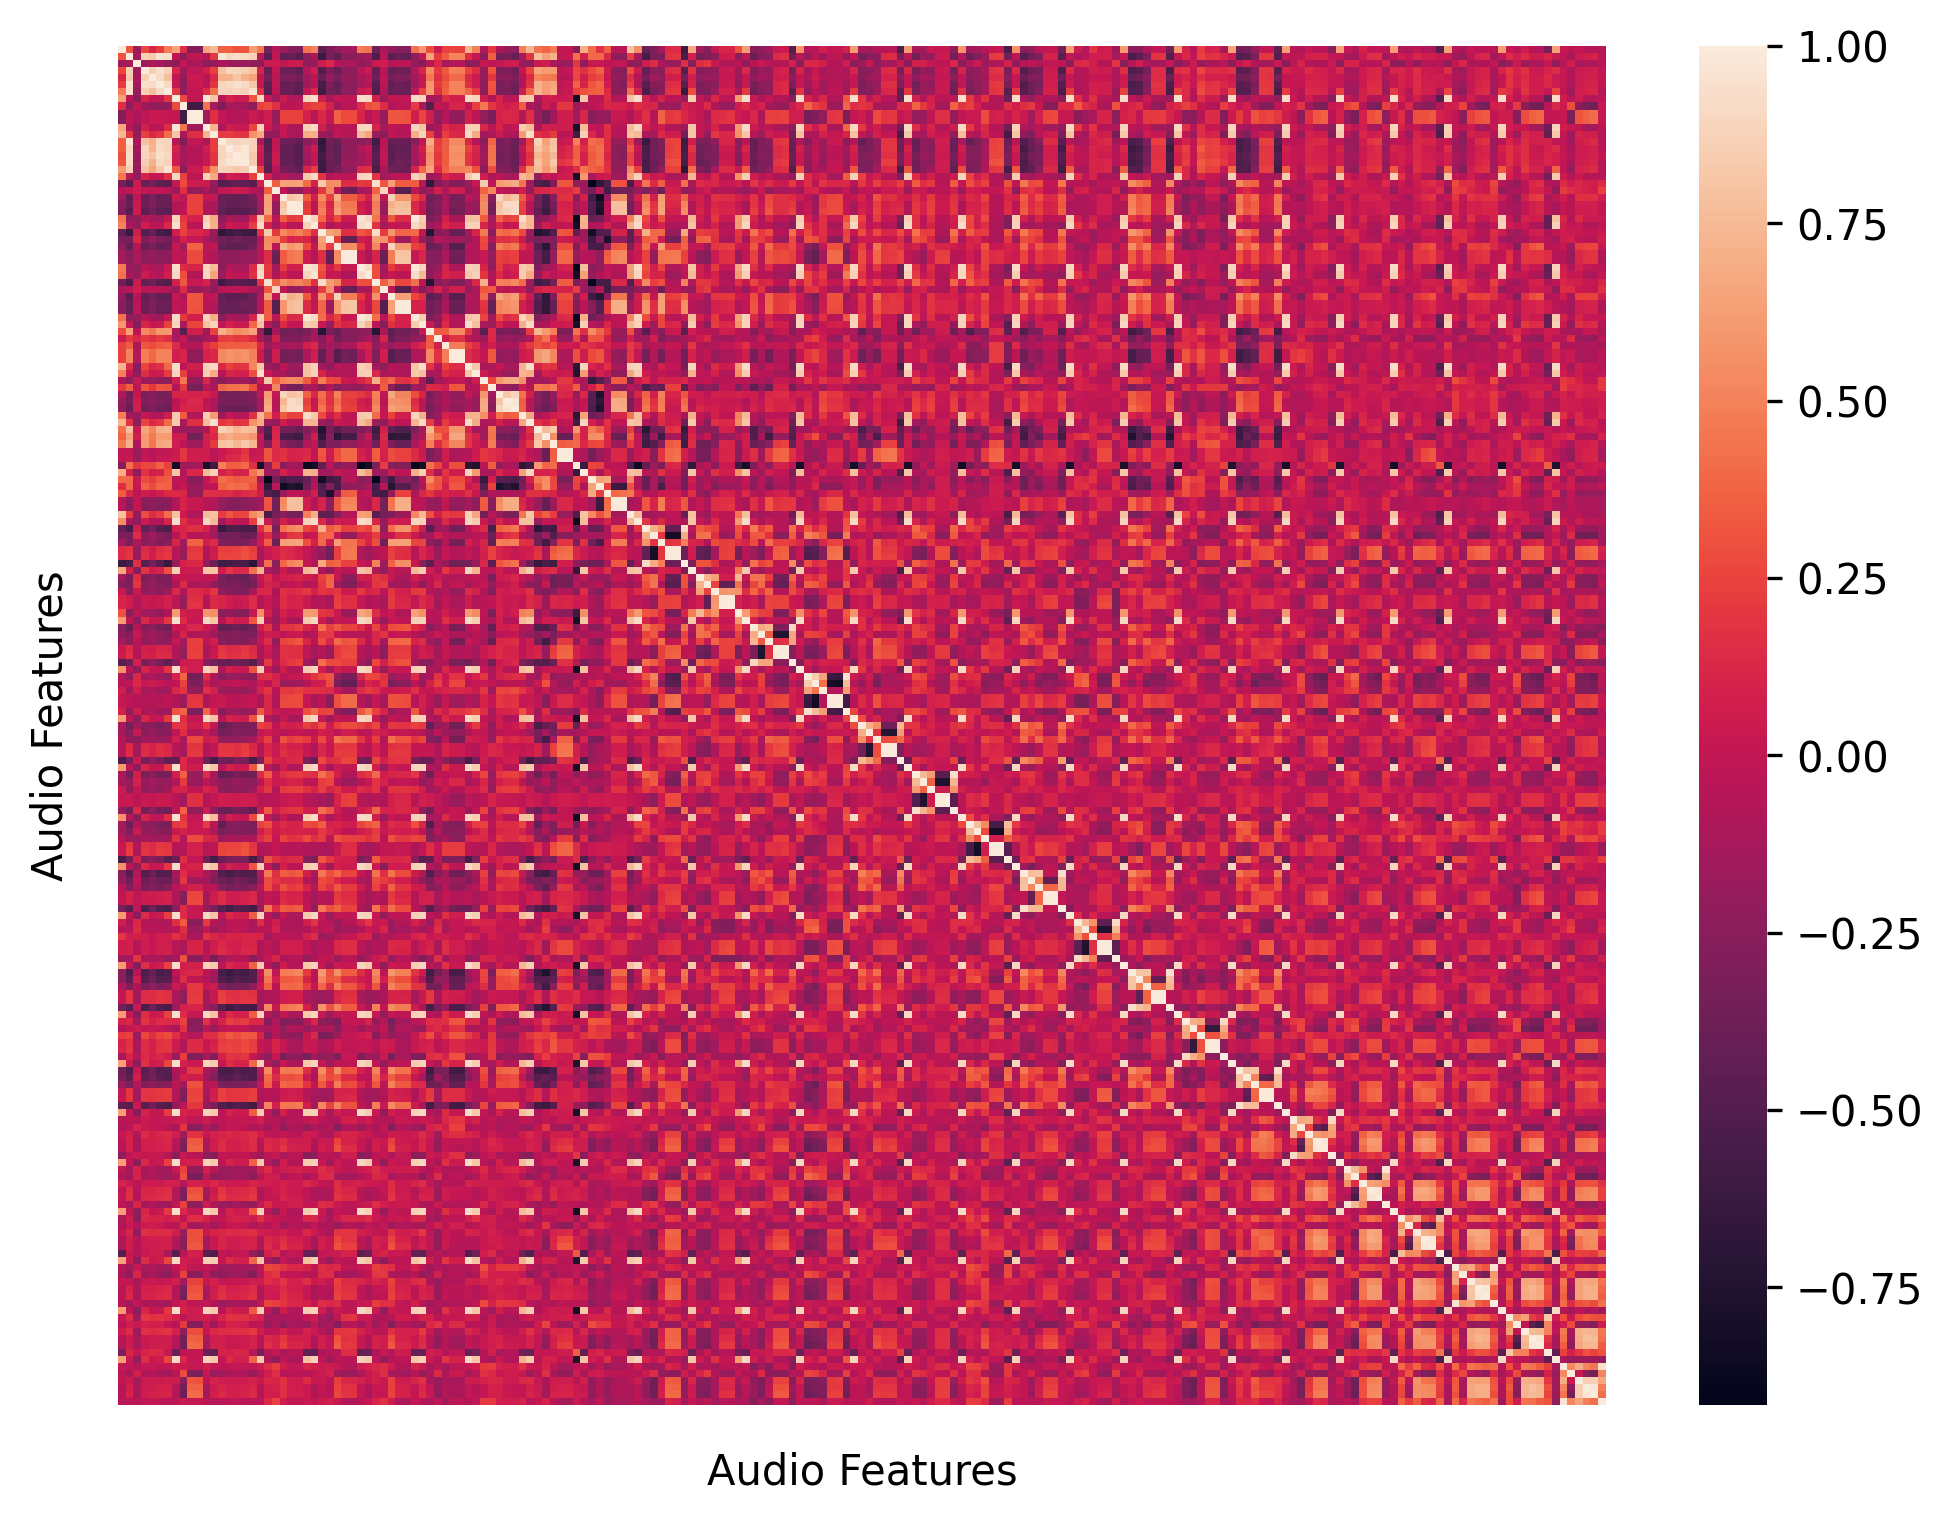

In [81]:
df_corr = df.iloc[:,4:].corr()
plt.figure(figsize=(8, 6))
g = sns.heatmap(df_corr, annot=False, fmt=".1f")
g.set_yticklabels([])
g.set_xticklabels([])
g.tick_params(left=False, bottom=False)
# plt.title("Correlation Matrix of Audio Features")
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
plt.show()

In [8]:
def hight_corr_feat_elimination(df_corr, high_corr):
    corr_pairs = df_corr.unstack()
    # order pairs of features with highest correlations
    strong_pairs = []
    for pair in corr_pairs.items():
        if pair[0][0] != pair[0][1] and abs(pair[1]) > high_corr\
            and ((pair[0][1], pair[0][0]), abs(pair[1])) not in strong_pairs:
            strong_pairs.append(((pair[0][0], pair[0][1]), abs(pair[1])))
    strong_pairs.sort(reverse=True, key=lambda x: abs(x[1]))

    eliminated_feats = set()

    for pair in strong_pairs:
        corr = pair[1]
        f1 = pair[0][0]
        f2 = pair[0][1]

        if corr > high_corr and \
            f1 not in eliminated_feats and \
            f2 not in eliminated_feats:
            mean_corr_f1 = np.mean(abs(df_corr[f1].values))
            mean_corr_f2 = np.mean(abs(df_corr[f2].values))

            eliminated_feats.add(f1 if mean_corr_f1 > mean_corr_f2 else f2)

    return eliminated_feats

In [6]:
df_corr = df.iloc[:,4:].corr()
eliminated_feats = hight_corr_feat_elimination(df_corr, 0.55)
print(len(eliminated_feats))
print(eliminated_feats)

143
{'std_mfcc9', 'std_mfcc15', 'sum_spec_bw', 'sum_mfcc2', 'sum_mfcc17', 'spikes_mfcc7', 'max_mfcc18', 'std_mfcc16', 'spikes_spec_bw', 'spikes_mfcc6', 'mean_mfcc8', 'var_zcr', 'std_mel_spect', 'mean_spec_bw', 'std_mfcc14', 'min_mfcc15', 'max_mfcc4', 'sum_spec_cent', 'std_spec_cent', 'std_mfcc17', 'mean_mfcc4', 'sum_mfcc19', 'mean_mfcc3', 'sum_mfcc6', 'sum_mfcc1', 'max_mfcc19', 'std_mfcc12', 'sum_mfcc16', 'spikes_mfcc1', 'var_mfcc17', 'std_spec_rolloff', 'spikes_mfcc9', 'min_mfcc6', 'sum_mfcc9', 'spikes_mfcc5', 'spikes_mfcc8', 'spikes_mfcc20', 'min_mfcc8', 'min_mfcc11', 'mean_mfcc11', 'mean_mfcc14', 'std_spec_cont', 'max_spec_bw', 'mean_rms', 'var_mfcc18', 'std_mfcc2', 'std_mfcc6', 'mean_mfcc12', 'std_mfcc19', 'var_spec_cent', 'std_mfcc3', 'mean_mfcc9', 'mean_mfcc6', 'sum_mfcc15', 'sum_mfcc10', 'spikes_spec_cont', 'var_spec_rolloff', 'mean_mfcc7', 'max_mfcc2', 'spikes_mfcc16', 'spikes_mfcc10', 'mean_mel_spect', 'sum_spec_rolloff', 'spikes_mfcc3', 'max_rms', 'min_mfcc16', 'std_mfcc10', 

In [83]:
[df.drop(feat, inplace=True, axis=1) for feat in eliminated_feats]
num_features = len(df.columns)-4
print(f"Number of features after high correlation elimination: {num_features}")
print(set(df.columns[4:]))

Number of features after high correlation elimination: 50
{'sum_mfcc20', 'max_mfcc11', 'max_mfcc14', 'min_mfcc5', 'var_mfcc14', 'var_mfcc4', 'min_spec_cont', 'max_mfcc3', 'min_mfcc17', 'mean_mfcc19', 'mean_mfcc15', 'max_mfcc6', 'sum_mfcc18', 'min_mfcc20', 'min_mfcc19', 'var_mfcc15', 'spikes_spec_cent', 'min_mel_spect', 'var_mfcc10', 'min_mfcc12', 'mean_mfcc16', 'max_mfcc1', 'var_mfcc3', 'std_chroma_stft', 'var_spec_cont', 'min_mfcc14', 'var_mel_spect', 'max_mfcc9', 'max_mfcc7', 'max_spec_cont', 'min_spec_cent', 'var_mfcc2', 'var_mfcc8', 'var_mfcc13', 'var_spec_bw', 'max_mfcc5', 'max_mfcc8', 'var_mfcc6', 'var_mfcc9', 'max_mfcc13', 'var_mfcc12', 'max_mfcc12', 'mean_zcr', 'min_mfcc7', 'var_mfcc11', 'mean_spec_cont', 'min_zcr', 'min_mfcc10', 'var_mfcc1', 'max_mfcc10'}


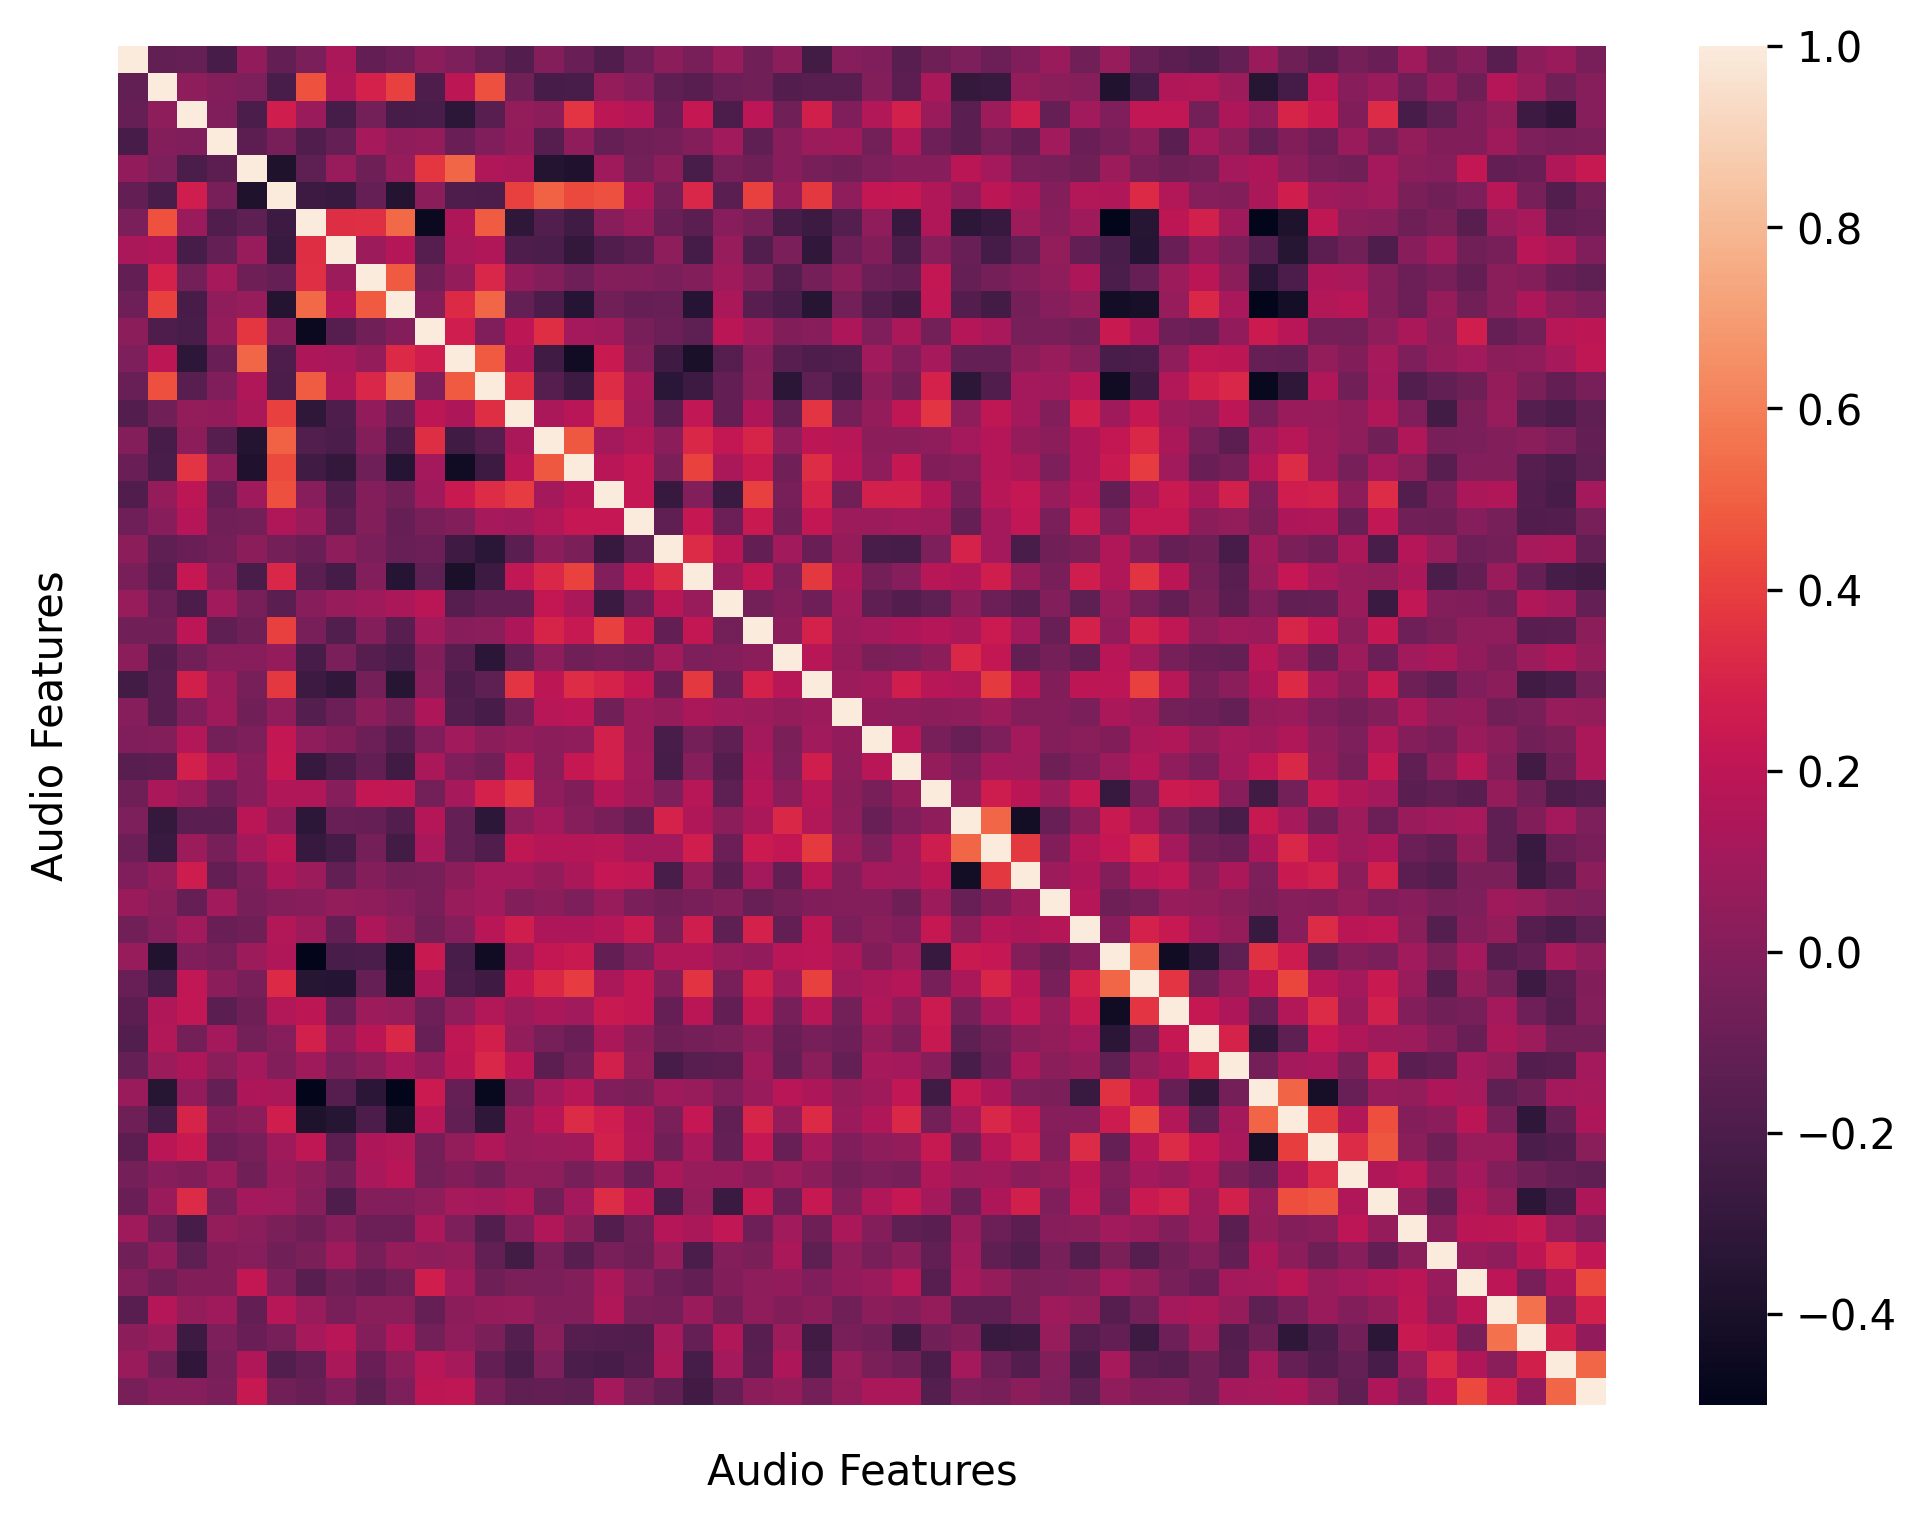

In [84]:
plt.figure(figsize=(8, 6))
df_corr = df.iloc[:,4:].corr()
g = sns.heatmap(df_corr, annot=False, fmt=".2f")
g.set_yticklabels([])
g.set_xticklabels([])
g.tick_params(left=False, bottom=False)
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
plt.show()

In [12]:
data = df.iloc[:,4:]
features = df.columns.values[4:]
labels = df["Emotion_Id"].values

## Compare Scores of Classifiers

In [156]:
def compare_clfs(clfs, data, labels):
    clfs_scores = defaultdict(dict)
    
    for clf in clfs:
        scores = cross_val_score(clf, data, labels, cv=5)
        
        # scores for each fold
        mean_score = np.mean(scores)
        std_score = np.std(scores)

        clfs_scores[clf.__class__.__name__.split("(")[0]] = (mean_score, std_score)
    
    return clfs_scores

In [157]:
%%capture
clfs = [
    DecisionTree(random_state=1, max_features=None),
    ExtraTree(random_state=1, max_features=None),
    RandomForest(random_state=1, max_features=None),
    ExtraTrees(random_state=1, max_features=None),
    XGB(random_state=1, objective="multi:softprob"),
    Ridge(random_state=1)
]

clfs_scores = compare_clfs(clfs, data, labels)

In [158]:
print(f"Classifiers Ordered by Highest Mean Accuracy:")
print(tabulate(
    pd.DataFrame().from_dict(dict(
        sorted(clfs_scores.items(), key=lambda item: item[1][0], reverse=True)
    ), orient="index", columns=["Mean", "Std"]), headers = 'keys'
))

print(f"\nClassifiers Ordered by Lowest Standard Deviation Accuracy:")
print(tabulate(
    pd.DataFrame().from_dict(dict(
        sorted(clfs_scores.items(), key=lambda item: item[1][1])
    ), orient="index", columns=["Mean", "Std"]), headers = 'keys'
))

Classifiers Ordered by Highest Mean Accuracy:
                            Mean        Std
----------------------  --------  ---------
XGBClassifier           0.436508  0.0332955
ExtraTreesClassifier    0.436508  0.0280598
RandomForestClassifier  0.41746   0.0181675
RidgeClassifier         0.416667  0.0125487
DecisionTreeClassifier  0.284127  0.0215312
ExtraTreeClassifier     0.242063  0.0242031

Classifiers Ordered by Lowest Standard Deviation Accuracy:
                            Mean        Std
----------------------  --------  ---------
RidgeClassifier         0.416667  0.0125487
RandomForestClassifier  0.41746   0.0181675
DecisionTreeClassifier  0.284127  0.0215312
ExtraTreeClassifier     0.242063  0.0242031
ExtraTreesClassifier    0.436508  0.0280598
XGBClassifier           0.436508  0.0332955


## Custom Feature Elimination with Propagation

In [159]:
def feature_elim(data, features, labels, n_features=1):
    data_c = data.copy()
    features = list(features)
    total_features = len(features)
    results = pd.DataFrame(columns=["Mean Acc", "Std Acc"])

    for _ in range(total_features-1, n_features-1, -1):
        acc = pd.DataFrame(columns=["Feature", "Mean Acc", "Std Acc"])
        
        for feat in tqdm(features):
            X_train = data_c.copy()

            X_train.drop(feat, inplace=True, axis=1)

            clf = RandomForest(random_state=1, max_features=None)
            scores = cross_val_score(clf, X_train, labels, cv=5)

            # mean score across all folds
            mean_score = np.mean(scores)
            std_score = np.std(scores)

            acc.loc[feat] = [feat, mean_score, std_score]

        acc_scaled = acc.copy(deep=True)
        acc_scaled[acc_scaled.columns[1]] = minmax_scale(acc_scaled[acc_scaled.columns[1]], (0, 1))
        acc_scaled[acc_scaled.columns[2]] = minmax_scale(acc_scaled[acc_scaled.columns[2]], (0, 1))
        acc_scaled = acc_scaled.values.tolist()
        worse_feat = sorted(acc_scaled, key=lambda x: x[1]*0.5 - x[2]*0.5, reverse=True)[0]
        worse_feat = acc.loc[acc['Feature'] == worse_feat[0]].values[0]
        data_c.drop(worse_feat[0], inplace=True, axis=1)
        features.remove(worse_feat[0])
        results.loc[worse_feat[0]] = [worse_feat[1], worse_feat[2]]

    return results

In [160]:
custom_feat_elim_df = feature_elim(data, features, labels, 1)
custom_feat_elim_df.to_csv("custom_feat_elim.csv")
custom_feat_elim_df

100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


,Mean Acc,Std Acc
var_mfcc6,0.417460,0.003888
var_spec_bw,0.423810,0.007695
mean_mfcc19,0.417460,0.005264
min_mfcc7,0.418254,0.005383
max_mfcc11,0.416667,0.005019
min_mfcc14,0.421429,0.008474
min_spec_cont,0.411905,0.002970
var_mfcc12,0.421429,0.006827
var_mfcc13,0.421429,0.005264
mean_mfcc16,0.414286,0.004047


In [31]:
def energy_method(df, energy_perc, col1, col2=None):
    eliminated_feats = []
    cumulative_energy = 0

    if col2:
        total = 0

        arr1 = minmax_scale(list(df[col1].values), (0, 1))
        arr2 = minmax_scale(list(df[col2].values), (0, 1))

        for i, _ in enumerate(df.iterrows()):
            total += arr1[i]*0.5 - arr2[i]*0.5

        for i, feat_cols in enumerate(df.iterrows()):
            feat = feat_cols[0]
            val = arr1[i]*0.5 - arr2[i]*0.5
            cumulative_energy += val
            eliminated_feats.append(feat)
            if (cumulative_energy * 100 / total) >= energy_perc:
                break
    else:
        total = np.sum(df[col1].values)
        i = 0
        for feat, columns in df.iterrows():
            i += 1
            val = columns[col1]
            cumulative_energy += val
            eliminated_feats.append(feat)
            if (cumulative_energy * 100 / total) >= energy_perc:
                break
        
    return eliminated_feats, i

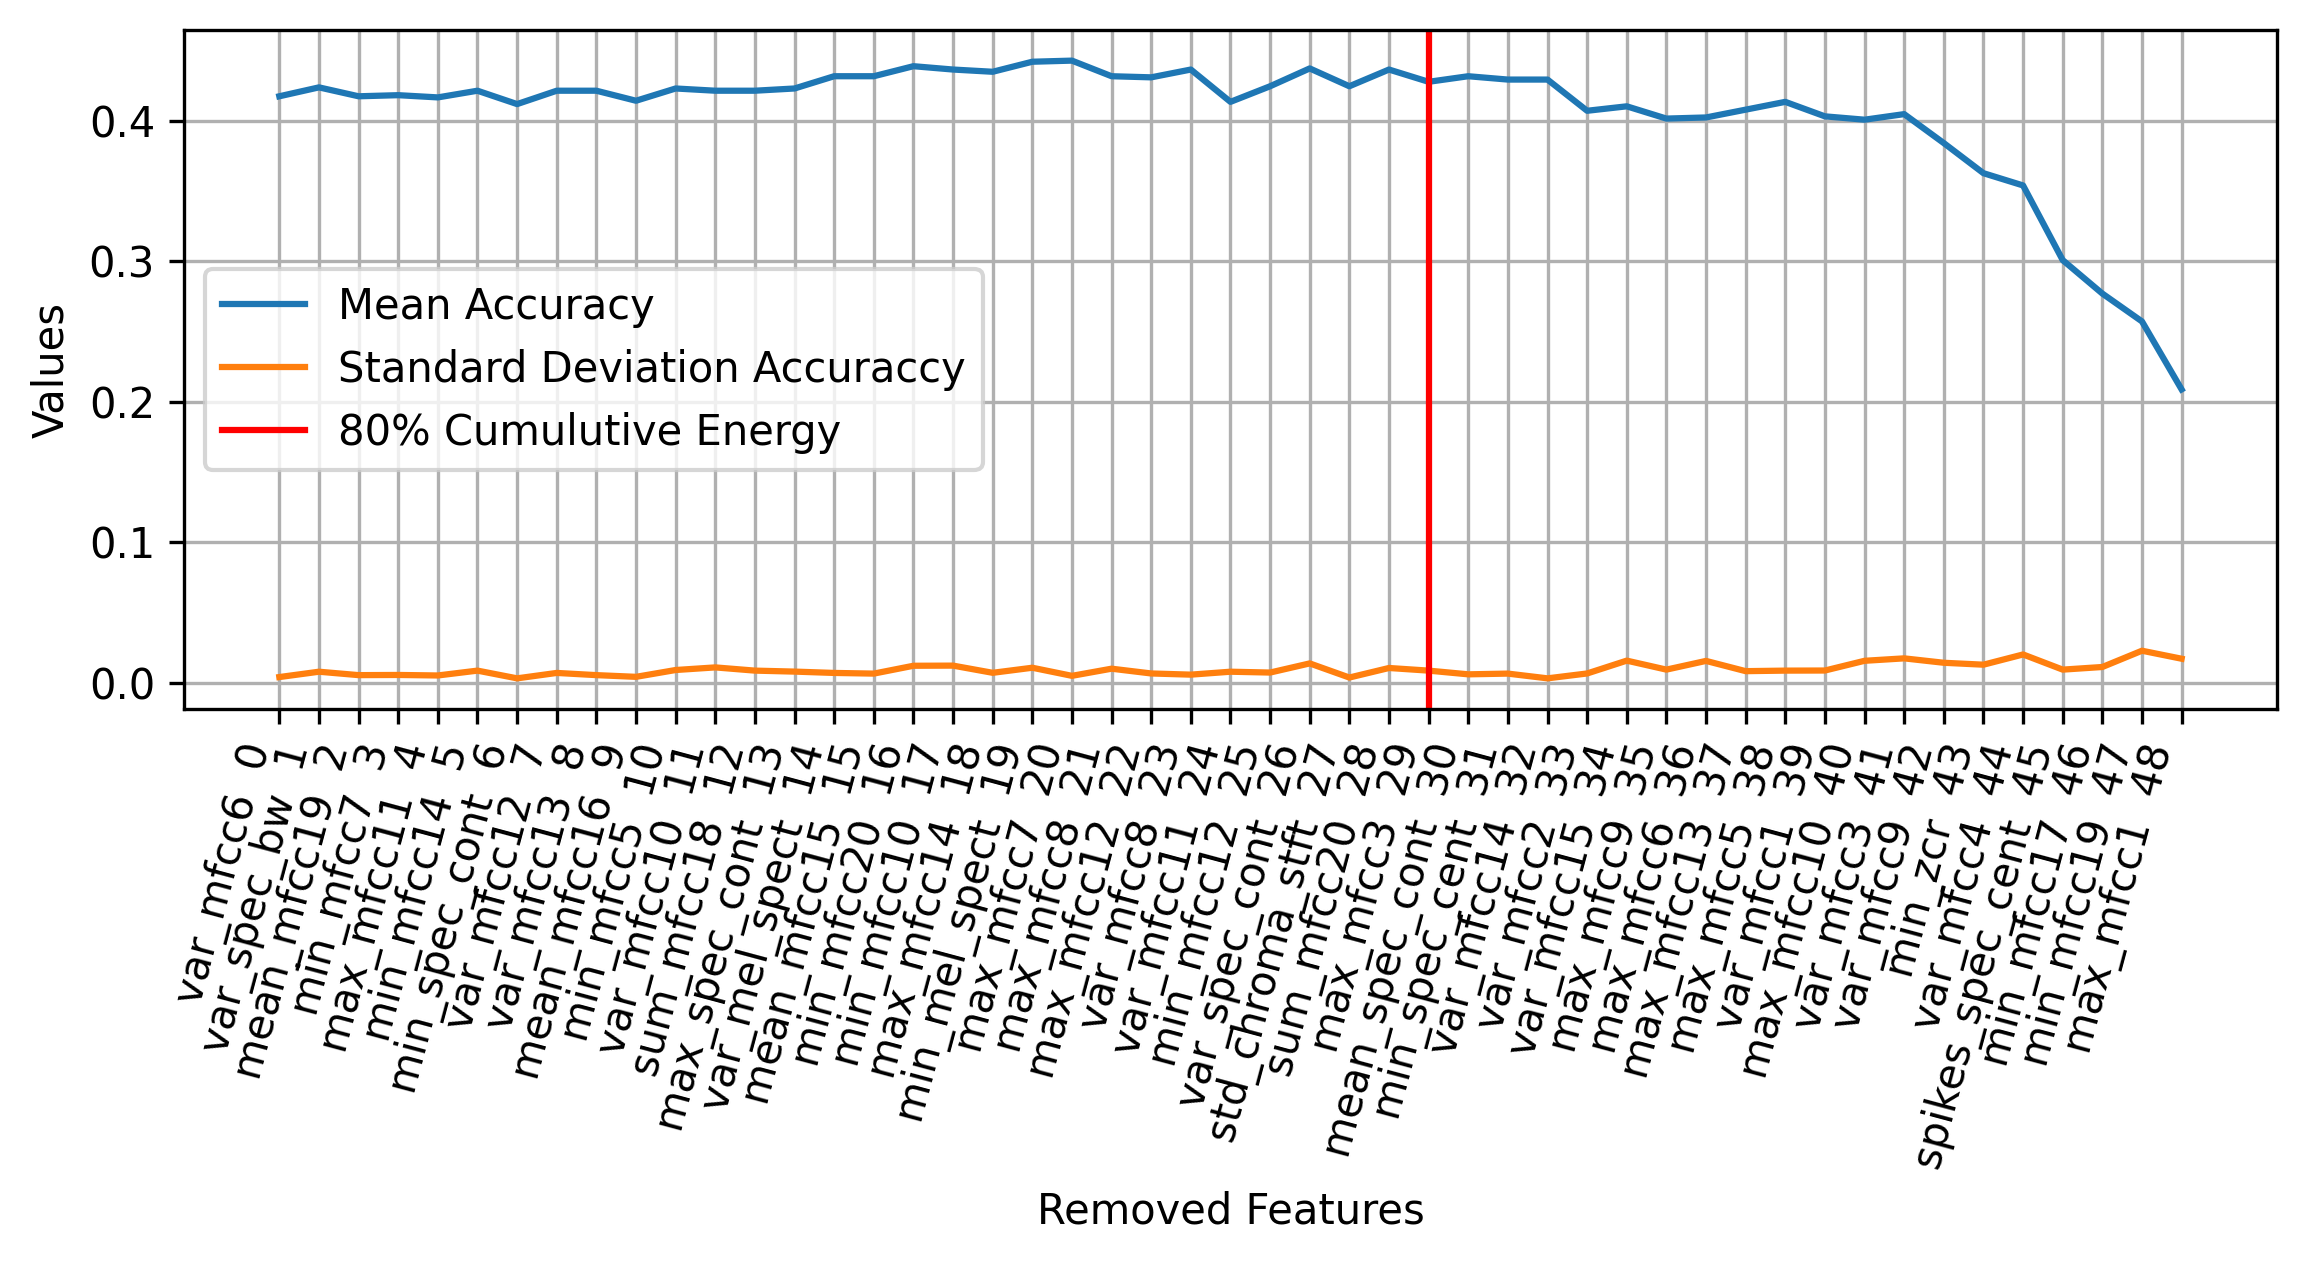

In [93]:
custom_feat_elim_df = pd.read_csv("custom_feat_elim.csv", index_col=0)
custom_elim_feats, custom_i = energy_method(custom_feat_elim_df, 80, "Mean Acc", "Std Acc")
fig = plt.figure(figsize=(9,3))
ax = plt.axes()
plt.ylabel("Values")
plt.xlabel("Removed Features")
plt.grid()
plt.setp(ax.get_xticklabels(), ha="right", rotation=75)
x_labels = [f"{custom_feat_elim_df.index.values[i]}  {i}" for i in range(len(custom_feat_elim_df.index.values))]
ax.plot(x_labels, custom_feat_elim_df['Mean Acc'].values, label="Mean Accuracy")
ax.plot(x_labels, custom_feat_elim_df['Std Acc'].values, label="Standard Deviation Accuraccy")
ax.axvline(x = custom_i, color = 'r', label="80% Cumulutive Energy")
plt.legend()

## Feature Elimination with Backward Propagation

- Less 1 feature

In [163]:
sfs1 = sfs(RandomForest(random_state=1, max_features=None), k_features=num_features-1, forward=False, cv=5, n_jobs=8)
sfs1 = sfs1.fit(data, labels)
print(sfs1.k_score_)
feat_names = set(sfs1.k_feature_names_)
left_out_features = [feat for feat in features if feat not in feat_names]
print(left_out_features)

0.4246031746031746
['max_mfcc12']


- For All Features

In [164]:
feat_elim = {}
df_train = data.copy()
for i in range(num_features-1, 0, -1):
    sfs1 = sfs(RandomForest(random_state=1, max_features=None), k_features=i, forward=False, cv=5, n_jobs=8)
    sfs1 = sfs1.fit(df_train, labels)
    feat_names = set(sfs1.k_feature_names_)
    eliminated_f = [feat for feat in features if feat not in feat_names and feat not in feat_elim][0]
    feat_elim[eliminated_f] = sfs1.k_score_
    df_train.drop(eliminated_f, inplace=True, axis=1)

In [165]:
feat_elim_df = pd.DataFrame().from_dict(feat_elim, orient="index", columns=["Accuracy"])
feat_elim_df.to_csv('feat_elim.csv')
print(tabulate(feat_elim_df.iloc[:10,:], headers = 'keys'))

                 Accuracy
-------------  ----------
max_mfcc12       0.424603
max_mfcc1        0.422222
min_spec_cont    0.434127
var_mfcc8        0.439683
var_mfcc9        0.437302
max_mfcc14       0.445238
max_mfcc11       0.437302
min_spec_cent    0.438889
mean_mfcc16      0.429365
max_mfcc9        0.438889


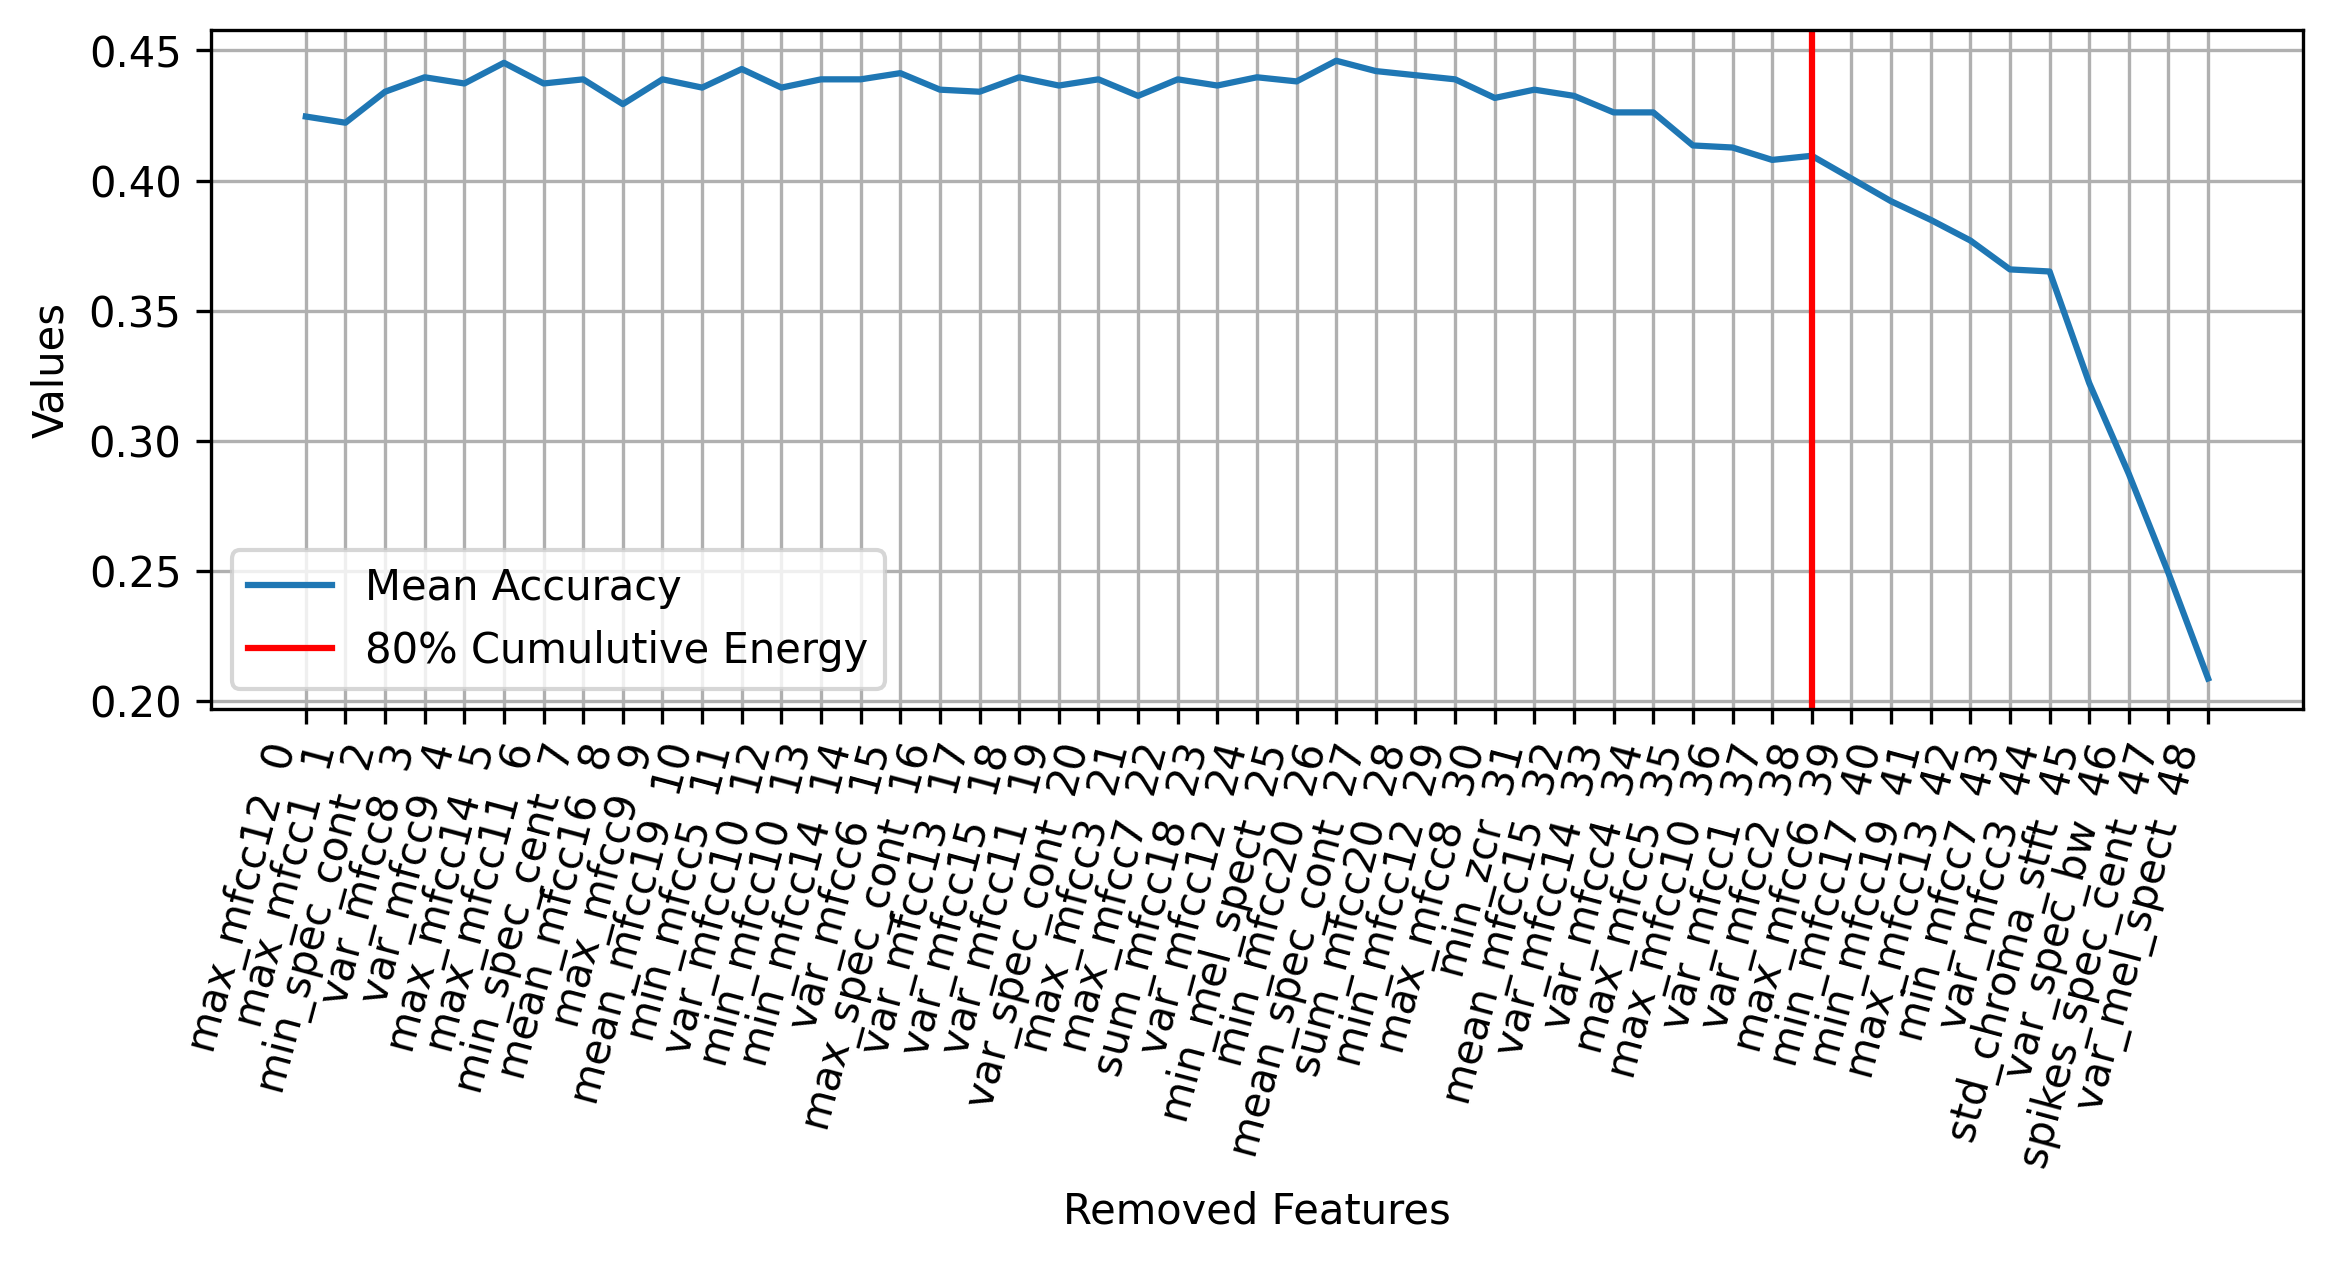

In [95]:
feat_elim_df = pd.read_csv("feat_elim.csv", index_col=0)
elim_feats, i = energy_method(feat_elim_df, 80, "Accuracy")
fig = plt.figure(figsize=(9, 3))
ax = plt.axes()
plt.ylabel("Values")
plt.xlabel("Removed Features")
plt.grid()
plt.setp(ax.get_xticklabels(), ha="right", rotation=75)
x_labels = [f"{feat_elim_df.index.values[i]}  {i}" for i in range(len(feat_elim_df.index.values))]
ax.plot(x_labels, feat_elim_df['Accuracy'].values, label="Mean Accuracy")
ax.axvline(x = i, color = 'r', label="80% Cumulutive Energy")
plt.legend()

In [39]:
common_elim_feats = [x for x in custom_elim_feats if x in elim_feats]
print('Feature Elimination with Propagation - Keeping 80% "Energy"\n')

print(f"Number of Eliminated Features Using:\n\t-Mean Accuracy as the Decider Metric: {len(elim_feats)}")
print(f"\t-Mean and Standard Deviation Accuracy as the Decider Metrics: {len(custom_elim_feats)}\n")
print(f"Common Eliminated Features betwen the two: {len(common_elim_feats)}")

Feature Elimination with Propagation - Keeping 80% "Energy"

Number of Eliminated Features Using:
	-Mean Accuracy as the Decider Metric: 38
	-Mean and Standard Deviation Accuracy as the Decider Metrics: 30

Common Eliminated Features betwen the two: 26


In [15]:
data_elim_feats = data.copy(deep=True)
[data_elim_feats.drop(feat, inplace=True, axis=1) for feat in common_elim_feats]
num_features = len(data_elim_feats.columns)
features = data_elim_feats.columns.values
print(f"Number of Features After Eliminating Common Features: {num_features}")
print(set(features))

Number of Features After Eliminating Common Features: 24
{'var_mfcc15', 'min_mfcc17', 'std_chroma_stft', 'mean_zcr', 'min_zcr', 'var_mfcc4', 'spikes_spec_cent', 'var_spec_bw', 'max_mfcc6', 'min_mfcc19', 'max_mfcc13', 'max_mfcc5', 'var_mfcc9', 'min_mfcc7', 'var_mfcc1', 'max_mfcc1', 'max_mfcc9', 'var_mel_spect', 'mean_spec_cont', 'var_mfcc2', 'max_mfcc10', 'min_spec_cent', 'var_mfcc14', 'var_mfcc3'}


## PCA

In [16]:
pca = PCA(random_state=1)
data_scaled = StandardScaler().fit_transform(data)
data_pca = pca.fit_transform(data_scaled)
explained_variance = pca.explained_variance_ratio_
list(explained_variance).sort(reverse=True)
comp_var = {}
for i in range(1, len(explained_variance)+1):
    comp_var[i] = np.sum(explained_variance[:i])
pd.DataFrame().from_dict(comp_var, orient='index', columns=["Total Variance Ratio"])

,Total Variance Ratio
1,0.131856
2,0.237390
3,0.304335
4,0.352268
5,0.396824
6,0.436673
7,0.472372
8,0.506380
9,0.535949
10,0.561400


In [17]:
min_var = .9
threshold = 0.01
prev_exp_var = 0
for num_component, total_exp_var in comp_var.items():
    if total_exp_var >= min_var and abs(total_exp_var - prev_exp_var) <= threshold:
        break
    prev_exp_var = total_exp_var
num_component

32

In [18]:
pca = PCA(random_state=1)
data_scaled_elim = StandardScaler().fit_transform(data_elim_feats)
data_pca_elim = pca.fit_transform(data_scaled_elim)
explained_variance = pca.explained_variance_ratio_
list(explained_variance).sort(reverse=True)
comp_var_elim = {}
for i in range(1, len(explained_variance)+1):
    comp_var_elim[i] = np.sum(explained_variance[:i])
pd.DataFrame().from_dict(comp_var_elim, orient='index', columns=["Total Variance Ratio"])

,Total Variance Ratio
1,0.144710
2,0.279797
3,0.379039
4,0.451164
5,0.509049
6,0.564751
7,0.617457
8,0.664493
9,0.701790
10,0.735421


In [19]:
min_var = .9
threshold = 0.04
prev_exp_var = 0
for num_component_elim, total_exp_var in comp_var_elim.items():
    if total_exp_var >= min_var and abs(total_exp_var - prev_exp_var) <= threshold:
        break
    prev_exp_var = total_exp_var
num_component_elim

17

# Confusion Matrix for Predictions

In [20]:
def get_tick_labels(val, aro):
    if val and aro:
        return [
            '(0, 0) - sadness',
            '(0, 1) - anger, disgust, fear',
            '(1, 1) - happiness, surprise'
        ]
    elif val:
        return [
            '0 - Low Valence',
            '1 - High Valence'
        ]
    elif aro:
        return [
            '0 - Low Arousal',
            '1 - High Arousal'
        ]
    else:
        return [
            '0 - anger',
            '1 - disgust',
            '2 - fear',
            '3 - happiness',
            '4 - sadness',
            '5 - surprise'
        ]

In [21]:
'''
calculate multi-class classification and return related evaluation metrics
'''
def multi_class_classification(y_pred, labels):
    print("accuracy: ", metrics.accuracy_score(labels, y_pred))
    print("f1 score macro: ", metrics.f1_score(labels, y_pred, average='macro') )
    print("f1 score micro: ", metrics.f1_score(labels, y_pred, average='micro') )
    print("precision score: ", metrics.precision_score(labels, y_pred, average='macro') )
    print("recall score: ", metrics.recall_score(labels, y_pred, average='macro') )
    print("hamming_loss: ", metrics.hamming_loss(labels, y_pred))
    print("matthews_corrcoef: ", metrics.matthews_corrcoef(labels, y_pred) )
    print("zero_one_loss: ", metrics.zero_one_loss(labels, y_pred))

In [35]:
def plot_cm_predictions(clf, input_data, labels, cv=5, val=False, aro=False, scoring='accuracy', draw_corr_matrix=True, one_hot_encoding=pd.DataFrame()):
    if one_hot_encoding.empty:
        y_pred = cross_val_predict(clf, input_data, labels, cv=cv)
    else:
        y_pred = cross_val_predict(clf, input_data, one_hot_encoding, cv=cv)
        y_pred = y_pred.argmax(1)
        
    ticks = get_tick_labels(val, aro)

    multi_class_classification(y_pred, labels)
    print(metrics.classification_report(labels, y_pred, target_names=ticks))

    if draw_corr_matrix:
        cm = metrics.confusion_matrix(labels, y_pred)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix Predicted Labels")
        plt.xlabel("Emotions Labels")
        plt.ylabel("Emotions Labels")
        plt.yticks(rotation=0) 
        plt.show()

## 1 - With all initial features

accuracy:  0.46111111111111114
f1 score macro:  0.4538397598408479
f1 score micro:  0.46111111111111114
precision score:  0.4565660897809818
recall score:  0.4611111111111111
hamming_loss:  0.5388888888888889
matthews_corrcoef:  0.3549535047597228
zero_one_loss:  0.5388888888888889
               precision    recall  f1-score   support

    0 - anger       0.48      0.67      0.56       210
  1 - disgust       0.49      0.40      0.44       210
     2 - fear       0.42      0.33      0.37       210
3 - happiness       0.47      0.42      0.44       210
  4 - sadness       0.50      0.60      0.54       210
 5 - surprise       0.39      0.35      0.37       210

     accuracy                           0.46      1260
    macro avg       0.46      0.46      0.45      1260
 weighted avg       0.46      0.46      0.45      1260



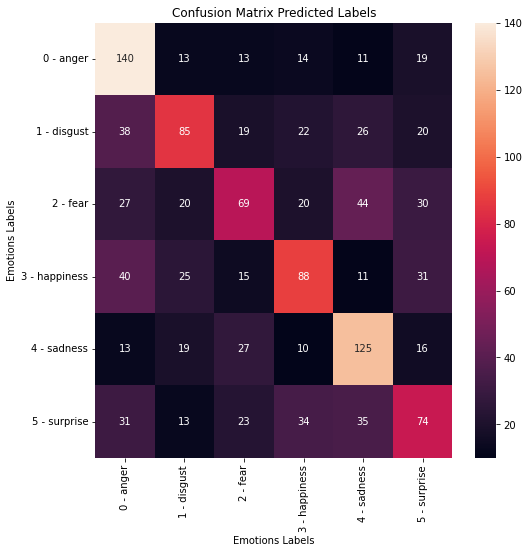

In [39]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), df[df.columns[4:]].values, labels)

## 1.1 - With high correlation elimination

accuracy:  0.4174603174603175
f1 score macro:  0.40879532186321854
f1 score micro:  0.4174603174603175
precision score:  0.41173256984057044
recall score:  0.4174603174603175
hamming_loss:  0.5825396825396826
matthews_corrcoef:  0.3026724119279003
zero_one_loss:  0.5825396825396825
               precision    recall  f1-score   support

    0 - anger       0.44      0.58      0.50       210
  1 - disgust       0.36      0.32      0.34       210
     2 - fear       0.43      0.33      0.37       210
3 - happiness       0.41      0.35      0.37       210
  4 - sadness       0.46      0.62      0.53       210
 5 - surprise       0.37      0.30      0.34       210

     accuracy                           0.42      1260
    macro avg       0.41      0.42      0.41      1260
 weighted avg       0.41      0.42      0.41      1260



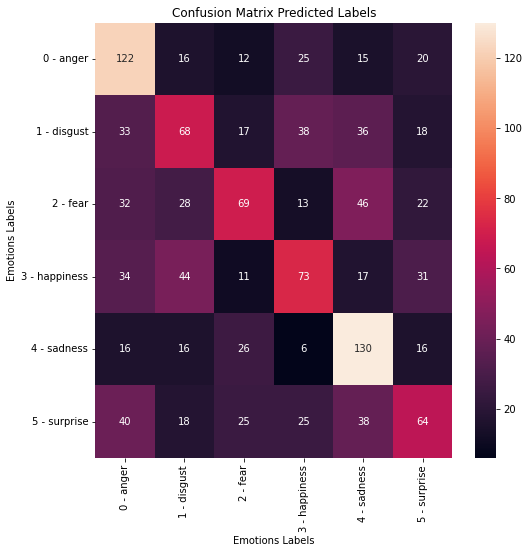

In [36]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data.values, labels)

## 1.1.1 With All Principal Components

accuracy:  0.39126984126984127
f1 score macro:  0.37264984918098465
f1 score micro:  0.3912698412698413
precision score:  0.3817219933635181
recall score:  0.39126984126984127
hamming_loss:  0.6087301587301587
matthews_corrcoef:  0.27357449506218656
zero_one_loss:  0.6087301587301588
               precision    recall  f1-score   support

    0 - anger       0.39      0.60      0.48       210
  1 - disgust       0.32      0.20      0.25       210
     2 - fear       0.33      0.28      0.30       210
3 - happiness       0.42      0.38      0.40       210
  4 - sadness       0.44      0.66      0.53       210
 5 - surprise       0.39      0.22      0.29       210

     accuracy                           0.39      1260
    macro avg       0.38      0.39      0.37      1260
 weighted avg       0.38      0.39      0.37      1260



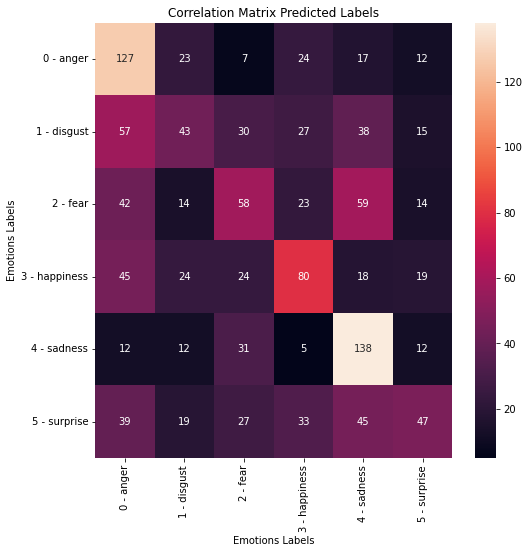

In [178]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data_pca, labels)

## 1.1.2 - With an Ideal Number of Principal Components

accuracy:  0.39126984126984127
f1 score macro:  0.3742060223751436
f1 score micro:  0.3912698412698413
precision score:  0.37804807097635745
recall score:  0.3912698412698412
hamming_loss:  0.6087301587301587
matthews_corrcoef:  0.2725733764708277
zero_one_loss:  0.6087301587301588
               precision    recall  f1-score   support

    0 - anger       0.41      0.60      0.49       210
  1 - disgust       0.33      0.19      0.24       210
     2 - fear       0.30      0.25      0.27       210
3 - happiness       0.42      0.41      0.42       210
  4 - sadness       0.44      0.62      0.52       210
 5 - surprise       0.37      0.27      0.31       210

     accuracy                           0.39      1260
    macro avg       0.38      0.39      0.37      1260
 weighted avg       0.38      0.39      0.37      1260



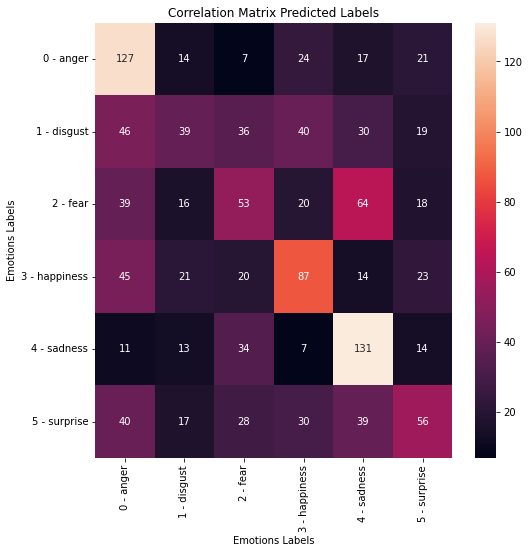

In [179]:
pca = PCA(n_components=num_component)
data_pca_ideal_comp = pca.fit_transform(data_scaled)
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data_pca_ideal_comp, labels)

## 1.1.3 - With Feature Elimination with Backward Propagation

accuracy:  0.4174603174603175
f1 score macro:  0.41127781263063623
f1 score micro:  0.4174603174603175
precision score:  0.4136542121186096
recall score:  0.4174603174603175
hamming_loss:  0.5825396825396826
matthews_corrcoef:  0.30219339676006807
zero_one_loss:  0.5825396825396825
               precision    recall  f1-score   support

    0 - anger       0.44      0.57      0.50       210
  1 - disgust       0.39      0.32      0.35       210
     2 - fear       0.44      0.35      0.39       210
3 - happiness       0.43      0.38      0.40       210
  4 - sadness       0.46      0.59      0.52       210
 5 - surprise       0.33      0.31      0.32       210

     accuracy                           0.42      1260
    macro avg       0.41      0.42      0.41      1260
 weighted avg       0.41      0.42      0.41      1260



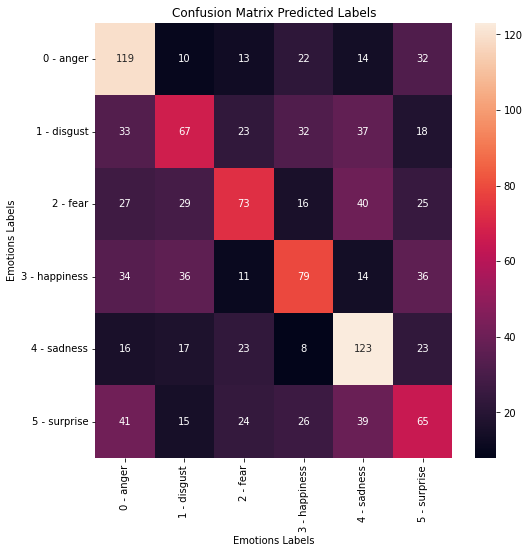

In [37]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data_elim_feats.values, labels)

## 1.1.3.1 - With All Principal Components

accuracy:  0.4015873015873016
f1 score macro:  0.3953591606873357
f1 score micro:  0.4015873015873016
precision score:  0.39746172240264666
recall score:  0.40158730158730155
hamming_loss:  0.5984126984126984
matthews_corrcoef:  0.28307564612899466
zero_one_loss:  0.5984126984126984
               precision    recall  f1-score   support

    0 - anger       0.39      0.51      0.44       210
  1 - disgust       0.43      0.32      0.37       210
     2 - fear       0.38      0.33      0.36       210
3 - happiness       0.36      0.36      0.36       210
  4 - sadness       0.50      0.60      0.55       210
 5 - surprise       0.33      0.28      0.30       210

     accuracy                           0.40      1260
    macro avg       0.40      0.40      0.40      1260
 weighted avg       0.40      0.40      0.40      1260



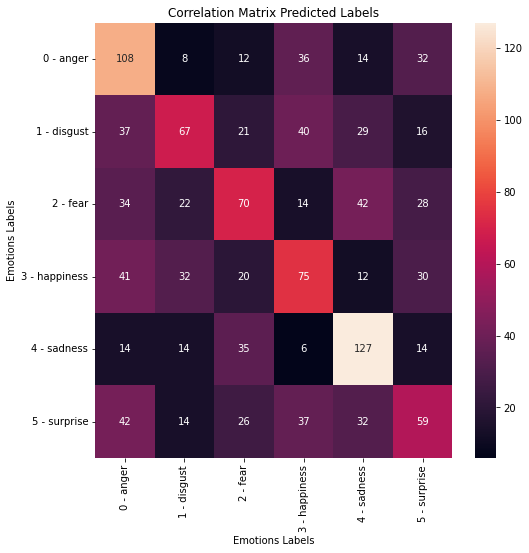

In [181]:
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_pca_elim, labels
)

## 1.3.1.2 - With an Ideal Number of Principal Components

accuracy:  0.38412698412698415
f1 score macro:  0.3790421909358849
f1 score micro:  0.38412698412698415
precision score:  0.37948577438376074
recall score:  0.3841269841269841
hamming_loss:  0.6158730158730159
matthews_corrcoef:  0.2617045519542626
zero_one_loss:  0.6158730158730159
               precision    recall  f1-score   support

    0 - anger       0.41      0.53      0.46       210
  1 - disgust       0.36      0.28      0.32       210
     2 - fear       0.36      0.34      0.35       210
3 - happiness       0.35      0.35      0.35       210
  4 - sadness       0.44      0.50      0.47       210
 5 - surprise       0.35      0.30      0.32       210

     accuracy                           0.38      1260
    macro avg       0.38      0.38      0.38      1260
 weighted avg       0.38      0.38      0.38      1260



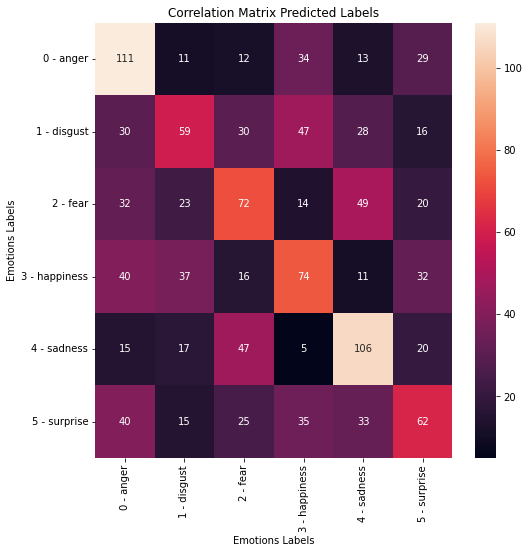

In [182]:
pca = PCA(n_components=num_component_elim)
data_pca_elim_ideal_comp = pca.fit_transform(data_scaled_elim)
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_pca_elim_ideal_comp, labels
)

## 1.3.1.2 - One vs Rest Classifier

accuracy:  0.43333333333333335
f1 score macro:  0.42421454139903997
f1 score micro:  0.43333333333333335
precision score:  0.42686427144207156
recall score:  0.43333333333333335
hamming_loss:  0.5666666666666667
matthews_corrcoef:  0.321802078095925
zero_one_loss:  0.5666666666666667
               precision    recall  f1-score   support

    0 - anger       0.47      0.56      0.51       210
  1 - disgust       0.40      0.30      0.34       210
     2 - fear       0.40      0.30      0.34       210
3 - happiness       0.42      0.43      0.43       210
  4 - sadness       0.47      0.65      0.54       210
 5 - surprise       0.41      0.36      0.38       210

     accuracy                           0.43      1260
    macro avg       0.43      0.43      0.42      1260
 weighted avg       0.43      0.43      0.42      1260



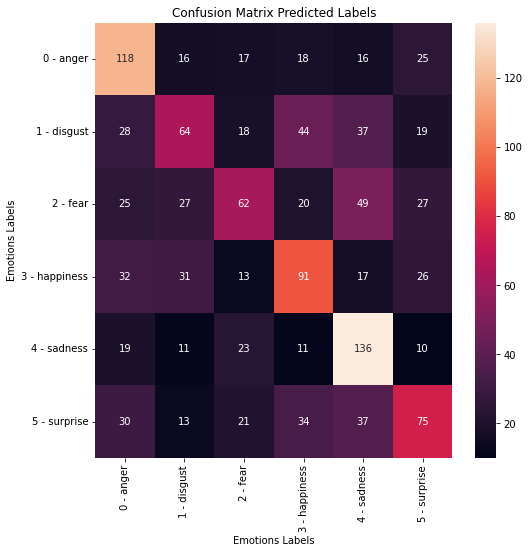

In [52]:
plot_cm_predictions(
    OneVsRestClassifier(RandomForest(random_state=1, max_features=None)),
    data_elim_feats.values, labels
)

accuracy:  0.45
f1 score macro:  0.4403421093734354
f1 score micro:  0.45
precision score:  0.4434739839628042
recall score:  0.45
hamming_loss:  0.55
matthews_corrcoef:  0.342044676933199
zero_one_loss:  0.55
               precision    recall  f1-score   support

    0 - anger       0.49      0.66      0.56       210
  1 - disgust       0.47      0.39      0.42       210
     2 - fear       0.38      0.27      0.32       210
3 - happiness       0.45      0.45      0.45       210
  4 - sadness       0.45      0.60      0.51       210
 5 - surprise       0.42      0.33      0.37       210

     accuracy                           0.45      1260
    macro avg       0.44      0.45      0.44      1260
 weighted avg       0.44      0.45      0.44      1260



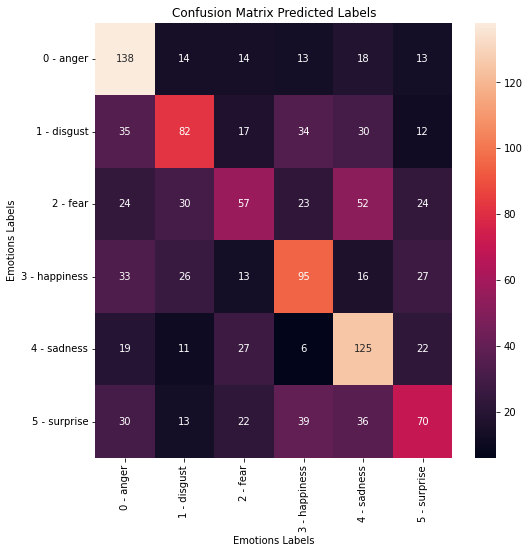

In [53]:
plot_cm_predictions(
    OneVsRestClassifier(RandomForest(random_state=1, max_features=None)),
    df[df.columns[4:]].values, labels
)

## Valence and Arousal

In [184]:
display(HTML('<a href="https://www.researchgate.net/figure/Emotions-in-valence-arousal-space-13_fig3_329718637"><img src="https://www.researchgate.net/profile/Ananya-Bhattacharjee/publication/329718637/figure/fig3/AS:704946219532291@1545083684893/Emotions-in-valence-arousal-space-13.ppm" alt="Emotions in valence-arousal space [13]"/></a>'))

In [46]:
emotions = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise'
}
emo_val = {
    'anger': 0,
    'disgust': 0,
    'fear': 0,
    'happiness': 1,
    'sadness': 0,
    'surprise': 1
}
emo_aro = {
    'anger': 1,
    'disgust': 1,
    'fear': 1,
    'happiness': 1,
    'sadness': 0,
    'surprise': 1
}
multi_pred = {
    (0, 0): 0,
    (0, 1): 1,
    (1, 1): 2
}
labels_val = [emo_val[emotions[e]] for e in labels]
labels_aro = [emo_aro[emotions[e]] for e in labels]
labels_val_aro = [multi_pred[(emo_val[emotions[e]], emo_aro[emotions[e]])] for e in labels]

## Classification for valence only

accuracy:  0.7015873015873015
f1 score macro:  0.619226429106481
f1 score micro:  0.7015873015873015
precision score:  0.6586152377076125
recall score:  0.6148809523809524
hamming_loss:  0.2984126984126984
matthews_corrcoef:  0.26997681063366674
zero_one_loss:  0.29841269841269846
                  precision    recall  f1-score   support

 0 - Low Valence       0.73      0.88      0.80       840
1 - High Valence       0.59      0.35      0.44       420

        accuracy                           0.70      1260
       macro avg       0.66      0.61      0.62      1260
    weighted avg       0.68      0.70      0.68      1260



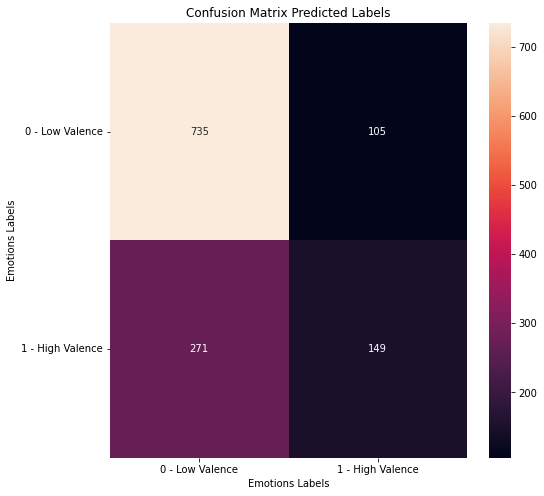

In [44]:
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_elim_feats.values, labels_val, val=True
)

## Classification for arousal only

accuracy:  0.8595238095238096
f1 score macro:  0.7042296669500326
f1 score micro:  0.8595238095238096
precision score:  0.7545644812188417
recall score:  0.6776190476190476
hamming_loss:  0.14047619047619048
matthews_corrcoef:  0.42527873547464173
zero_one_loss:  0.14047619047619042
                  precision    recall  f1-score   support

 0 - Low Arousal       0.62      0.40      0.49       210
1 - High Arousal       0.89      0.95      0.92      1050

        accuracy                           0.86      1260
       macro avg       0.75      0.68      0.70      1260
    weighted avg       0.84      0.86      0.85      1260



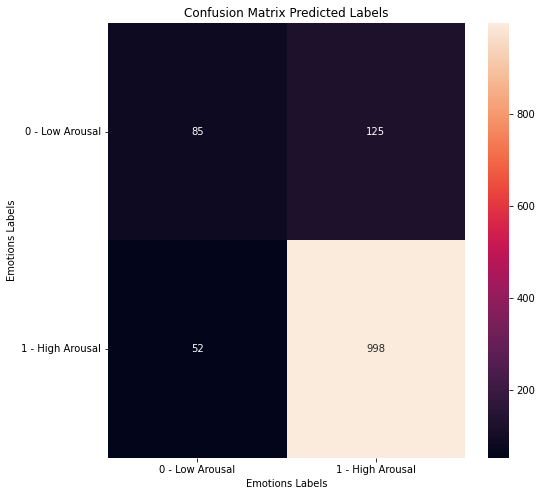

In [45]:
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_elim_feats.values, labels_aro, aro=True
)

## Classification for valence and arousal

### For all features

accuracy:  0.6
f1 score macro:  0.55163600691622
f1 score micro:  0.6
precision score:  0.5931393565621753
recall score:  0.5373015873015873
hamming_loss:  0.4
matthews_corrcoef:  0.31895636803529087
zero_one_loss:  0.4
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.57      0.40      0.47       210
(0, 1) - anger, disgust, fear       0.60      0.78      0.68       630
 (1, 1) - happiness, surprise       0.60      0.43      0.50       420

                     accuracy                           0.60      1260
                    macro avg       0.59      0.54      0.55      1260
                 weighted avg       0.60      0.60      0.59      1260



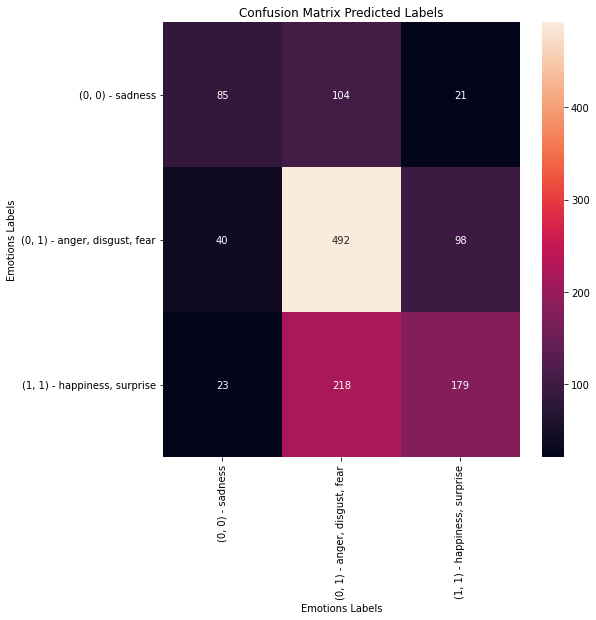

In [54]:
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    df[df.columns[4:]].values, labels_val_aro, val=True, aro=True
)

### For the features after high correlation and backward propagation

accuracy:  0.5833333333333334
f1 score macro:  0.5436354508341508
f1 score micro:  0.5833333333333334
precision score:  0.5742103012421285
recall score:  0.5343915343915344
hamming_loss:  0.4166666666666667
matthews_corrcoef:  0.29452229084009757
zero_one_loss:  0.41666666666666663
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.56      0.46      0.51       210
(0, 1) - anger, disgust, fear       0.59      0.76      0.66       630
 (1, 1) - happiness, surprise       0.57      0.39      0.46       420

                     accuracy                           0.58      1260
                    macro avg       0.57      0.53      0.54      1260
                 weighted avg       0.58      0.58      0.57      1260



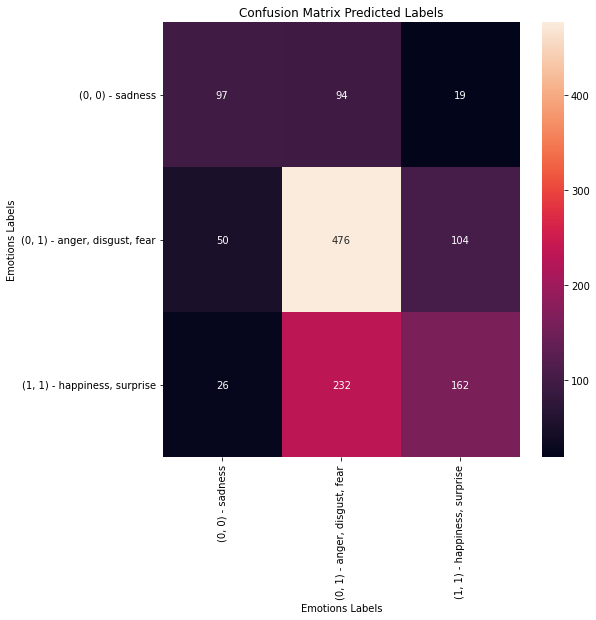

In [46]:
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

## Balanced Trees

accuracy:  0.5357142857142857
f1 score macro:  0.5324964750694111
f1 score micro:  0.5357142857142857
precision score:  0.5297891713216463
recall score:  0.5761904761904763
hamming_loss:  0.4642857142857143
matthews_corrcoef:  0.30369015800038424
zero_one_loss:  0.4642857142857143
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.41      0.71      0.52       210
(0, 1) - anger, disgust, fear       0.68      0.47      0.55       630
 (1, 1) - happiness, surprise       0.50      0.55      0.53       420

                     accuracy                           0.54      1260
                    macro avg       0.53      0.58      0.53      1260
                 weighted avg       0.57      0.54      0.54      1260



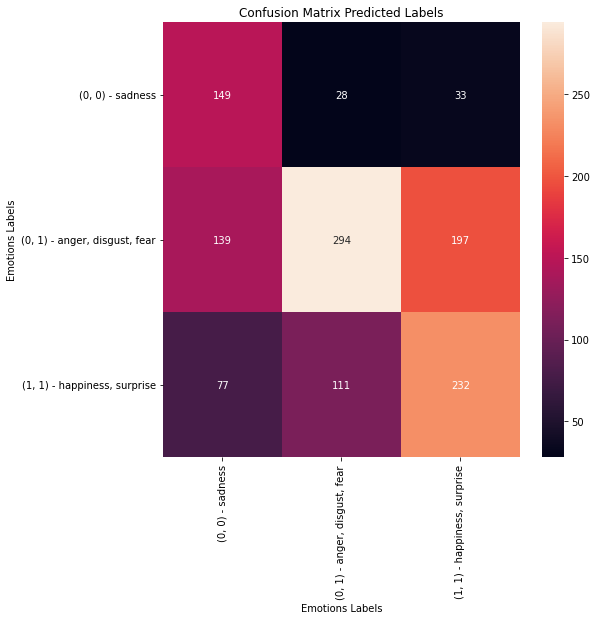

In [47]:
plot_cm_predictions(
    BalancedRandomForestClassifier(random_state=1, max_features=None),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

accuracy:  0.5507936507936508
f1 score macro:  0.5435758891750408
f1 score micro:  0.5507936507936508
precision score:  0.534993245124824
recall score:  0.5775132275132275
hamming_loss:  0.4492063492063492
matthews_corrcoef:  0.30656025333035264
zero_one_loss:  0.44920634920634916
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.43      0.70      0.53       210
(0, 1) - anger, disgust, fear       0.65      0.53      0.59       630
 (1, 1) - happiness, surprise       0.53      0.50      0.51       420

                     accuracy                           0.55      1260
                    macro avg       0.53      0.58      0.54      1260
                 weighted avg       0.57      0.55      0.55      1260



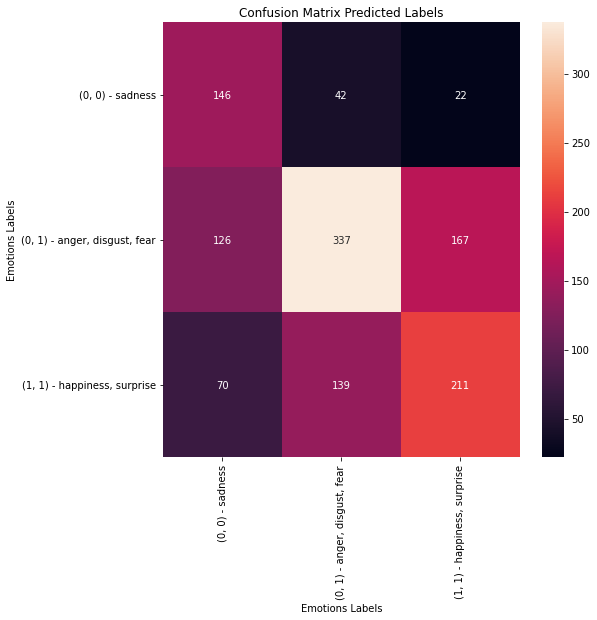

In [48]:
plot_cm_predictions(
    BalancedBaggingClassifier(
        RandomForest(random_state=1, max_features=None), 100, random_state=1, n_jobs=8
    ),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

accuracy:  0.5341269841269841
f1 score macro:  0.5313331649464414
f1 score micro:  0.5341269841269841
precision score:  0.5275941541656349
recall score:  0.5791005291005291
hamming_loss:  0.4658730158730159
matthews_corrcoef:  0.30161208346706553
zero_one_loss:  0.4658730158730159
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.40      0.74      0.52       210
(0, 1) - anger, disgust, fear       0.66      0.47      0.55       630
 (1, 1) - happiness, surprise       0.52      0.52      0.52       420

                     accuracy                           0.53      1260
                    macro avg       0.53      0.58      0.53      1260
                 weighted avg       0.57      0.53      0.54      1260



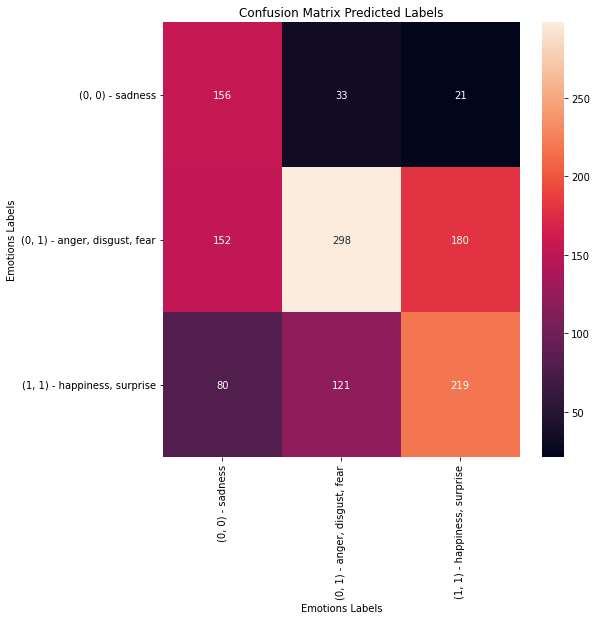

In [49]:
plot_cm_predictions(
    EasyEnsembleClassifier(
        100, RandomForest(random_state=1, max_features=None), random_state=1, n_jobs=8
    ),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

accuracy:  0.557936507936508
f1 score macro:  0.5019342953516253
f1 score micro:  0.557936507936508
precision score:  0.5575717576747535
recall score:  0.485978835978836
hamming_loss:  0.44206349206349205
matthews_corrcoef:  0.23652808978908788
zero_one_loss:  0.44206349206349205
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.57      0.30      0.40       210
(0, 1) - anger, disgust, fear       0.56      0.74      0.64       630
 (1, 1) - happiness, surprise       0.54      0.42      0.47       420

                     accuracy                           0.56      1260
                    macro avg       0.56      0.49      0.50      1260
                 weighted avg       0.56      0.56      0.54      1260



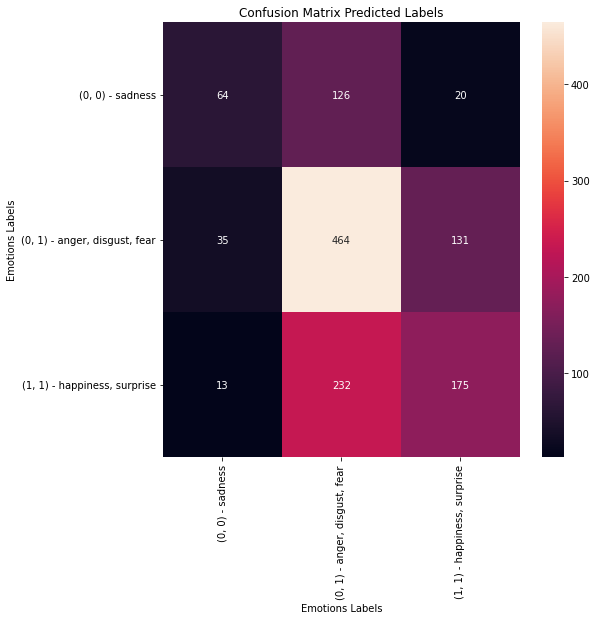

In [50]:
plot_cm_predictions(
    RUSBoostClassifier(
        RandomForest(random_state=1, max_features=None, n_jobs=8), n_estimators=100, random_state=1
    ),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

## Simple Deep Learning

### Model

In [40]:
def build_model_0(input_shape=(12, 1)):
    model = Sequential()
    model.add(Conv1D(64, 5, input_shape=input_shape))
    model.add(Activation('relu'))#2nd hidden layer
    model.add(Conv1D(64, 5, padding="same"))
    model.add(Activation('relu'))#3rd hidden layer
    model.add(Conv1D(64, 5, padding="same"))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))#Add fully connected layer.
    model.add(GlobalAveragePooling1D())
    model.add(Flatten())
    model.add(Dense(3))
    model.add(Activation('softmax'))
    # Compile Model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [41]:
build_model_0(input_shape=(data_elim_feats.shape[1], 1)).summary()

2022-05-19 20:29:16.913716: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            384       
                                                                 
 activation (Activation)     (None, 20, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            20544     
                                                                 
 activation_1 (Activation)   (None, 20, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 20, 64)            20544     
                                                                 
 activation_2 (Activation)   (None, 20, 64)            0         
                                                                 
 dropout (Dropout)           (None, 20, 64)            0

In [42]:
def build_model_1(input_shape=(12, 1)):
    model = Sequential()
    model.add(Conv1D(256, 5,padding='same', input_shape=input_shape)) #1
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5,padding='same')) #2
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(128, 5,padding='same')) #3
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5,padding='same')) #6
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(3)) #7
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [43]:
build_model_1(input_shape=(data_elim_feats.shape[1], 1)).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 24, 256)           1536      
                                                                 
 activation_4 (Activation)   (None, 24, 256)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 24, 128)           163968    
                                                                 
 activation_5 (Activation)   (None, 24, 128)           0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 128)           0         
 )                                                               
                                                      

### Compile and fit model

### Accuracy metric to evaluate performance, using adam optimizer, and categorical crossentropy as the loss function

In [44]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
estimator = KerasRegressor(build_fn=build_model_0, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])

/var/folders/p6/n3vpmbmn2s15fhn83qmld1800000gn/T/ipykernel_1197/858656607.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=build_model_0, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])


accuracy:  0.5087301587301587
f1 score macro:  0.3342038809772057
f1 score micro:  0.5087301587301587
precision score:  0.4954322743796427
recall score:  0.3724867724867725
hamming_loss:  0.49126984126984125
matthews_corrcoef:  0.091977075745735
zero_one_loss:  0.4912698412698413
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.50      0.09      0.15       210
(0, 1) - anger, disgust, fear       0.51      0.90      0.65       630
 (1, 1) - happiness, surprise       0.47      0.13      0.20       420

                     accuracy                           0.51      1260
                    macro avg       0.50      0.37      0.33      1260
                 weighted avg       0.50      0.51      0.42      1260



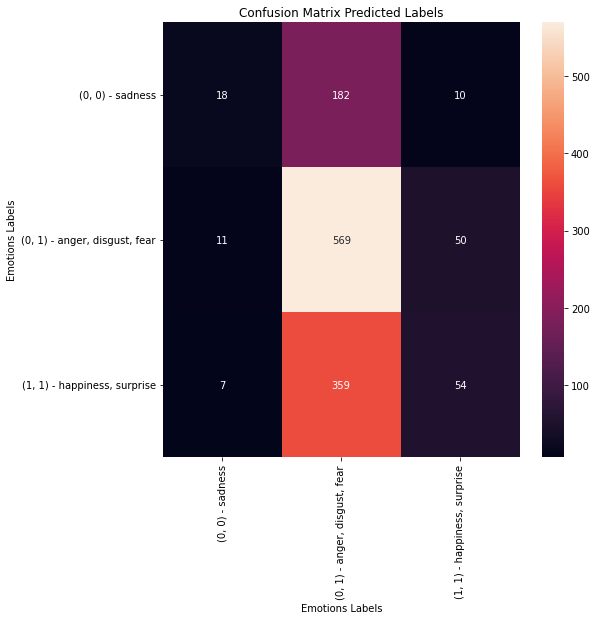

In [47]:
one_hot_encoding = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1],
}
one_hot_labels_val_aro = [one_hot_encoding[i] for i in labels_val_aro]

plot_cm_predictions(estimator, data_elim_feats, labels_val_aro, val=True, aro=True,
    one_hot_encoding=pd.DataFrame(one_hot_labels_val_aro))

/var/folders/p6/n3vpmbmn2s15fhn83qmld1800000gn/T/ipykernel_1197/42186902.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=build_model_1, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])


accuracy:  0.4928571428571429
f1 score macro:  0.34940645522629127
f1 score micro:  0.4928571428571429
precision score:  0.41438148399614255
recall score:  0.3812169312169312
hamming_loss:  0.5071428571428571
matthews_corrcoef:  0.08340195689849099
zero_one_loss:  0.5071428571428571
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.38      0.19      0.25       210
(0, 1) - anger, disgust, fear       0.52      0.86      0.65       630
 (1, 1) - happiness, surprise       0.35      0.09      0.15       420

                     accuracy                           0.49      1260
                    macro avg       0.41      0.38      0.35      1260
                 weighted avg       0.44      0.49      0.42      1260



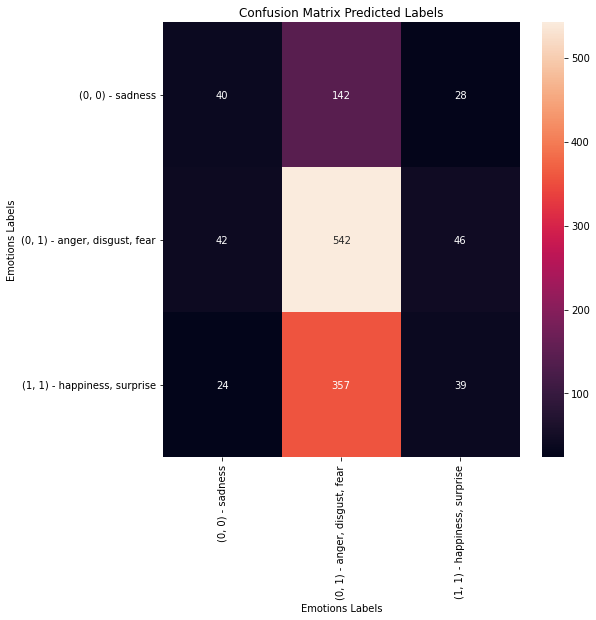

In [48]:
estimator = KerasRegressor(build_fn=build_model_1, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])

plot_cm_predictions(estimator, data_elim_feats, labels_val_aro, val=True, aro=True,
    one_hot_encoding=pd.DataFrame(one_hot_labels_val_aro))

## For all initial 194 features

/var/folders/p6/n3vpmbmn2s15fhn83qmld1800000gn/T/ipykernel_1197/4255217135.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=build_model_0, input_shape=(data.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])


accuracy:  0.5023809523809524
f1 score macro:  0.4114487508046871
f1 score micro:  0.5023809523809524
precision score:  0.46771421771421773
recall score:  0.4235449735449735
hamming_loss:  0.4976190476190476
matthews_corrcoef:  0.12478324762322404
zero_one_loss:  0.4976190476190476
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.47      0.32      0.38       210
(0, 1) - anger, disgust, fear       0.52      0.80      0.63       630
 (1, 1) - happiness, surprise       0.41      0.15      0.22       420

                     accuracy                           0.50      1260
                    macro avg       0.47      0.42      0.41      1260
                 weighted avg       0.48      0.50      0.45      1260



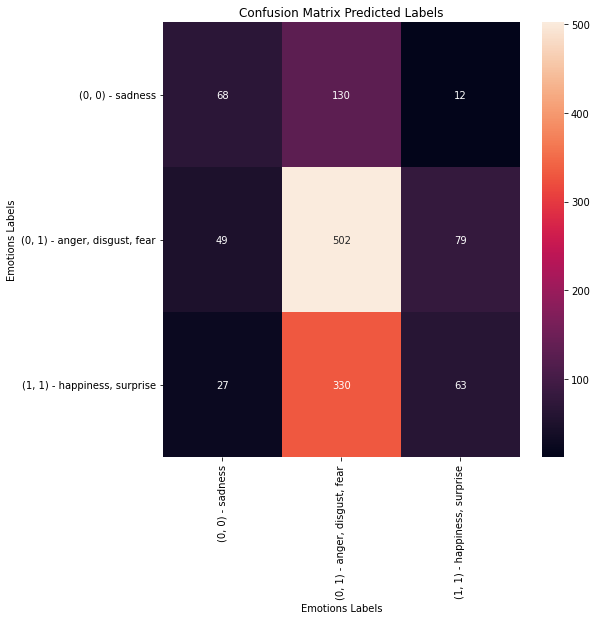

In [50]:
estimator = KerasRegressor(build_fn=build_model_0, input_shape=(data.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])

plot_cm_predictions(estimator, data, labels_val_aro, val=True, aro=True,
    one_hot_encoding=pd.DataFrame(one_hot_labels_val_aro))

/var/folders/p6/n3vpmbmn2s15fhn83qmld1800000gn/T/ipykernel_1197/1634601177.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=build_model_1, input_shape=(data.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])


accuracy:  0.48095238095238096
f1 score macro:  0.3597213915546839
f1 score micro:  0.48095238095238096
precision score:  0.40626549116288646
recall score:  0.3992063492063492
hamming_loss:  0.5190476190476191
matthews_corrcoef:  0.08339805958429153
zero_one_loss:  0.519047619047619
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.38      0.32      0.35       210
(0, 1) - anger, disgust, fear       0.51      0.81      0.63       630
 (1, 1) - happiness, surprise       0.32      0.06      0.10       420

                     accuracy                           0.48      1260
                    macro avg       0.41      0.40      0.36      1260
                 weighted avg       0.43      0.48      0.41      1260



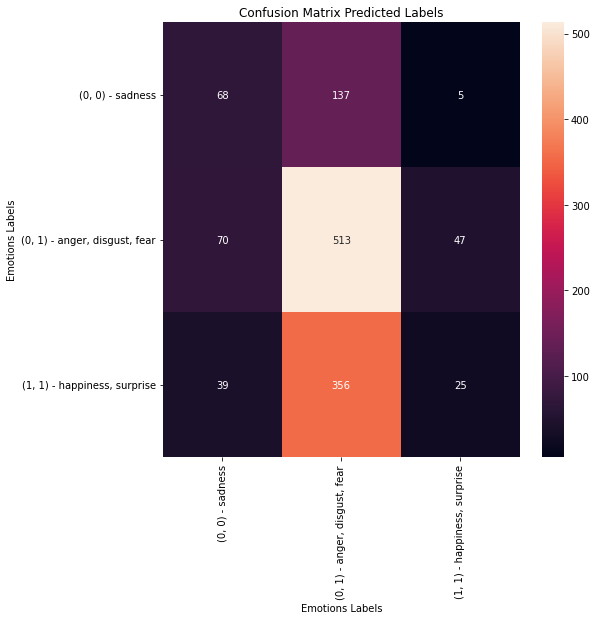

In [51]:
estimator = KerasRegressor(build_fn=build_model_1, input_shape=(data.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])

plot_cm_predictions(estimator, data, labels_val_aro, val=True, aro=True,
    one_hot_encoding=pd.DataFrame(one_hot_labels_val_aro))